In [59]:
%matplotlib inline

import sys
sys.path.append('../')

import itertools
import time

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('seaborn-white')
import pandas as pd
import seaborn as sns
import numpy as np

import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)


from scipy.stats import norm, skew
from scipy import stats


import boolipy
api = boolipy.api.Api()


The scikit-learn version is 0.21.3.


In [60]:
# GLOBAL VARIALBES FOR NOTEBOOK
SHOW_MAP = False
ALL_DATA_ANALYSS = False

# GLOBAL VARIABLES FOR API
FRIDHEMSPLAN = [59.334438, 18.029522]
CENTER = ",".join([str(x) for x in FRIDHEMSPLAN])
DIM = "500,2000"
LIMIT = 1000
MAX_LIVING_AREA = 55
ENDPOINT = "sold"

#parameters = {"center": CENTER, "dim": DIM, "limit": LIMIT, "maxLivingArea": MAX_LIVING_AREA}
parameters = {"center": CENTER, "dim": DIM, "limit": LIMIT}
#parameters = {"q": "kungsholmen", "limit": LIMIT, "maxLivingArea": MAX_LIVING_AREA }
#parameters = {"q": "kungsholmen", "limit": LIMIT}

In [61]:
# return an array of all the requests
data = api.get(endpoint=ENDPOINT, parameters=parameters, follow=True)

In [62]:
# debug data from requests
# flattern data
df = pd.DataFrame.from_dict(data)
#print("Data extracted info: totalCount: {}, limit: {}, offset: {}"data[0])

# Check data

In [63]:
df.shape

(3834, 19)

In [64]:
df.columns

Index(['location', 'listPrice', 'rent', 'floor', 'livingArea',
       'additionalArea', 'source', 'rooms', 'published', 'constructionYear',
       'objectType', 'booliId', 'soldDate', 'soldPrice', 'apartmentNumber',
       'soldPriceSource', 'url', 'plotArea', 'isNewConstruction'],
      dtype='object')

In [65]:
# define how do we want to change the data
from haversine import haversine, Unit


def location_tuple(x): 
    loc = x['location']['position']
    return [loc['latitude'], loc['longitude']]
def source_name(x): return x["source"]["name"]
def norm_price(x): return x["soldPrice"]/x["livingArea"]

def time_published(x): return x["soldDate"]-x["published"]
def source_name(x): return x["source"]["name"]
def price_increased(x): return x["soldPrice"] - x["listPrice"]
# convert location to tuple
def location_tuple(x): 
    loc = x['location']['position']
    return (loc['latitude'], loc['longitude'])

def dist_center(x, center = CENTER): 
    cloc = center
    if isinstance(center, str):
        cloc = tuple([float(l) for l in center.split(',')])
    # using default location
    #loc = x['location']['position']
    #c = (loc['latitude'], loc['longitude'])
    
    # using new loc_tuple
    c = x['loc_tuple']

    return haversine(c, cloc, unit=Unit.METERS)

def street_name(x):
    import re
    address = x['location']['address']['streetAddress']
    # remove the number
    return re.sub("(\s\d+\w?)", '', address)

def street_number(x):
    import re
    address = x['location']['address']['streetAddress']
    # remove the number
    return re.sub("(.*\s)", '', address)

def log_transform(feature, x=None):
    if x is None:
        x = ddf

    return np.log1p(x[feature].values)

def quadratic(feature, x=None):
    if x is None:
        x = ddf
    return x[feature]**2
    
df['loc_tuple'] = df.apply(location_tuple, axis=1)
df['source_name'] = df.apply(source_name, axis=1)
df['norm_price'] = df.apply(norm_price, axis=1)

df['soldDate'] = pd.to_datetime(df['soldDate'], format="%Y-%m-%d") 
df['soldQuarter'] = df['soldDate'] + pd.offsets.QuarterBegin(n=0)
df['soldYear'] = df['soldDate'].apply(lambda x: x.year)
df['soldMonth'] = df['soldDate'].apply(lambda x: x.month)

df['street_name'] = df.apply(street_name, axis=1)
df['street_number'] = df.apply(street_number, axis=1)

df['published'] = pd.to_datetime(df['published']) 

df['time_published'] = df.apply(time_published, axis=1)
df['source_name'] = df.apply(source_name, axis=1)
df['price_increased'] = df.apply(price_increased, axis=1)

df['hasBalcony'] = df['additionalArea'].apply(lambda x: 1 if x > 0 else 0)
df['dist_center'] = df.apply(dist_center, axis=1)
df['dist_ocean'] = df.apply(lambda x: x['location'].get('distance', {}).get('ocean', None), axis=1)

# Convert numeric variables to categorical
df['soldYear'] = df['soldYear']
df['soldMonth'] = df['soldMonth']
df['constructionYear'] = df['constructionYear']

In [66]:
## DEFINES VARIABLES FOR MODEL
boolean_vars = ["hasBalcony"]
discrete_vars = ["rooms", "floor", "soldYear", "soldMonth", "constructionYear"]
categorical_vars = ["street_name", "street_number"]
quantitative_vars = ["livingArea"]

In [67]:
#print("Unique Quarters: {}".format(len(df['soldQuarter'].unique())))
#print("Unique sources of info: {}".format(df['source_name'].unique()))
#print("Unique streets of info: {}".format(df['street'].unique()))

# Plot apartments

In [10]:
if SHOW_MAP:
    import folium

    # zoom_start as a function of the dim?

    m = folium.Map(
        location=FRIDHEMSPLAN,
        zoom_start=14
    )


    #folium.Marker(FRIDHEMSPLAN, popup='Center of the univers').add_to(m)

    def get_popup_str(x): 
        return '{} </br> size: {} </br> price: {} </br> date: {}'.format(x['location']['address']['streetAddress'], x['livingArea'], x['soldPrice'], x['soldDate'])

    for index, row in df.iterrows():
        folium.Marker(row['loc_tuple'], popup=get_popup_str(row)).add_to(m)

    m



# Analize our soldPrice
Getting guide from https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python

In [11]:
TARGET = 'soldPrice'
df[TARGET].describe()

count    3.835000e+03
mean     4.425262e+06
std      1.810879e+06
min      1.400000e+06
25%      3.150000e+06
50%      3.960000e+06
75%      5.300000e+06
max      1.712000e+07
Name: soldPrice, dtype: float64

In [12]:
df['soldDate'].describe()
min(df['soldDate'])

Timestamp('2012-08-31 00:00:00')

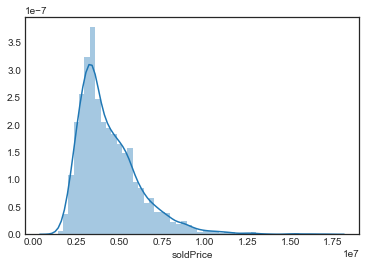

In [13]:
sns.distplot(df[TARGET]);

In [14]:
#skewness and kurtosis
print("Skewness: %f" % df['soldPrice'].skew())
print("Kurtosis: %f" % df['soldPrice'].kurt())

Skewness: 1.577813
Kurtosis: 4.183223


## Relationship with numerical variables

In [15]:
df.columns
num_variables = ['livingArea', 'listPrice', 'rent', 'soldDate', 'dist_ocean']

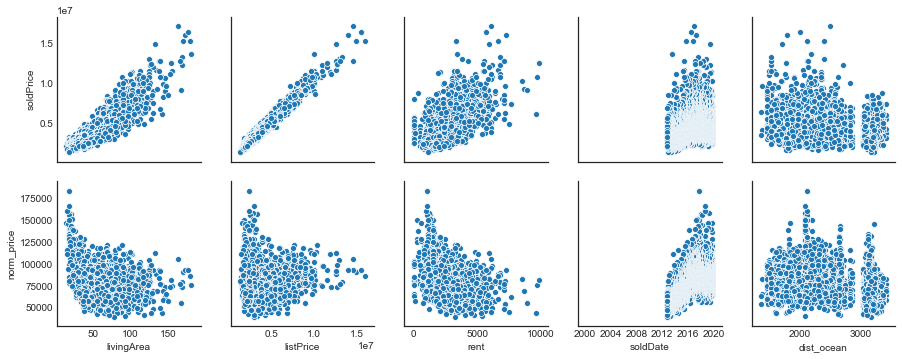

In [16]:
sns.pairplot(df, x_vars=num_variables, y_vars=[TARGET, 'norm_price'])

(734746.0, 737666.3603494625)

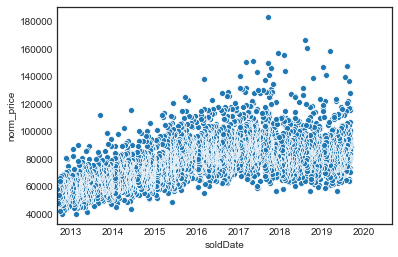

In [17]:
f = ax = sns.scatterplot(data=df, x='soldDate', y='norm_price')
ax.set_xlim(min(df['soldDate']),)

(734746.0, 737666.3531048386)

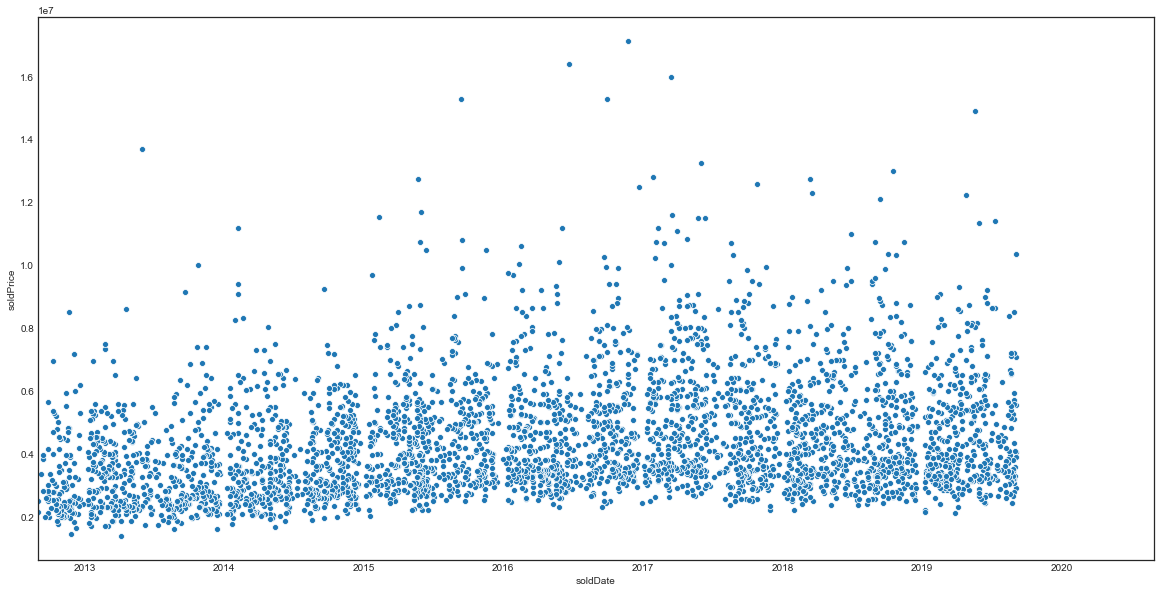

In [18]:
plt.figure(figsize=(20, 10))
ax = sns.scatterplot(data=df, x='soldDate', y='soldPrice')

ax.set_xlim(min(df['soldDate']),)

(734747.0, 737757.7031048388)

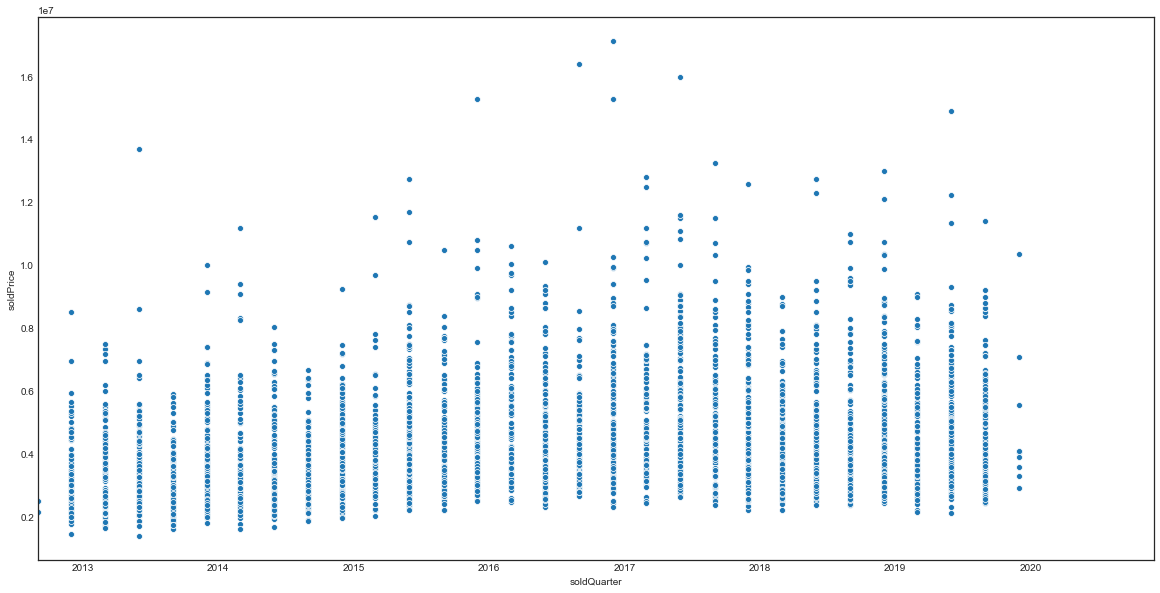

In [19]:
plt.figure(figsize=(20, 10))
ax = sns.scatterplot(data=df, x='soldQuarter', y='soldPrice')

ax.set_xlim(min(df['soldQuarter']),)

# Relationship with categorical variables?

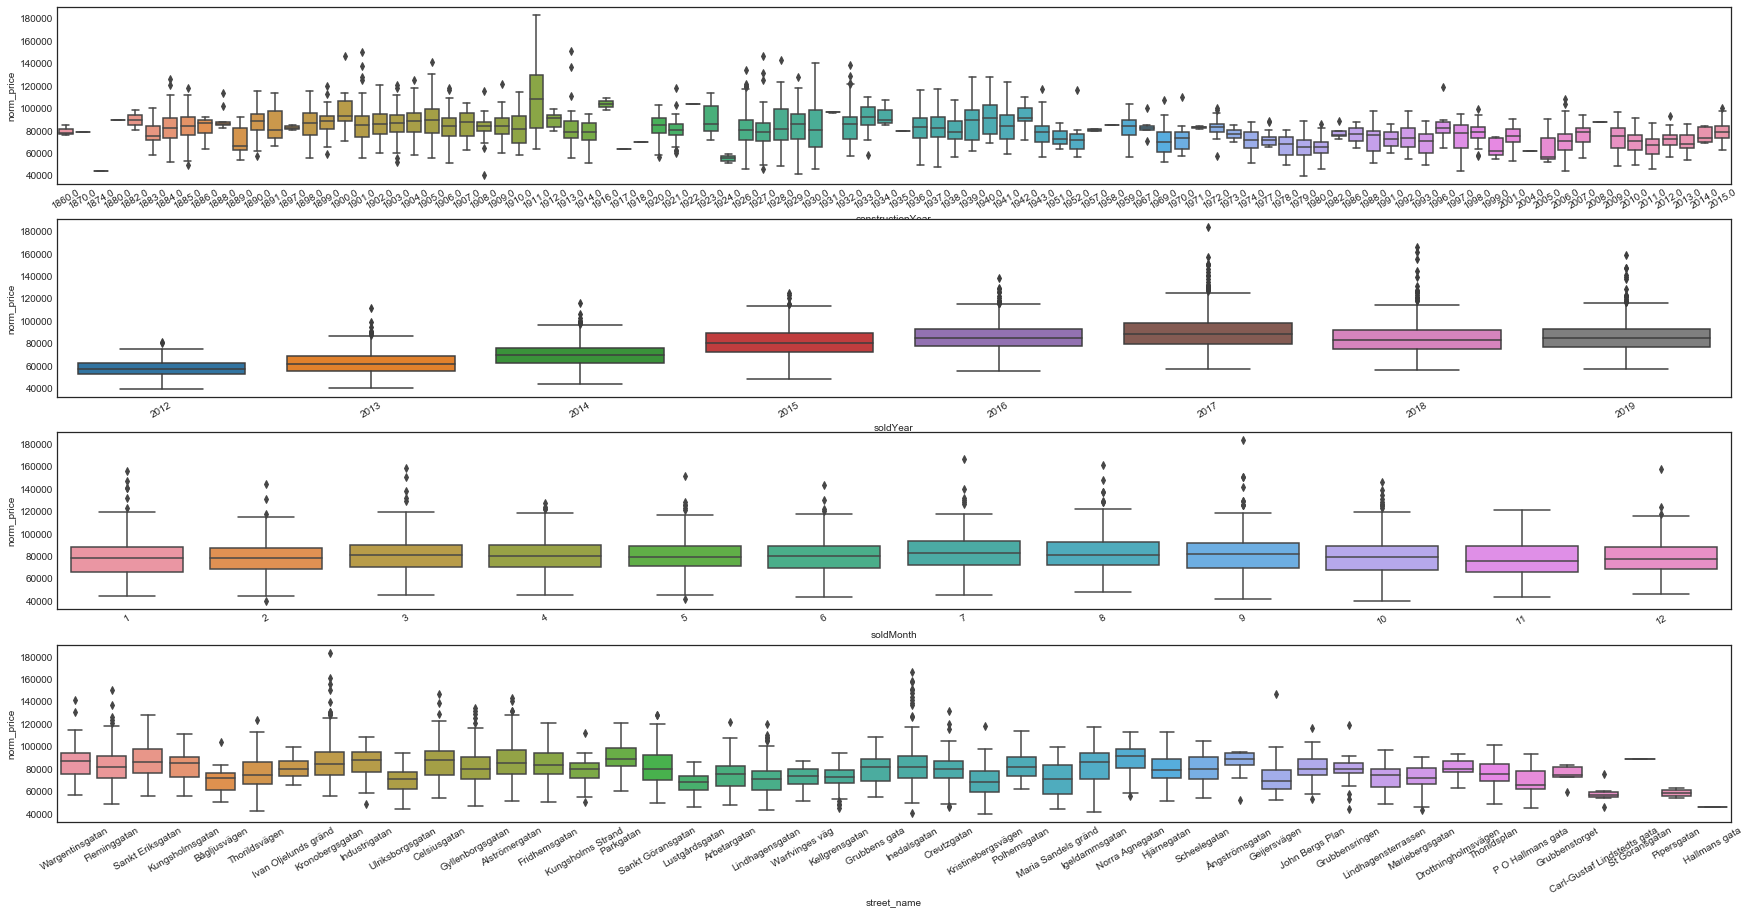

In [20]:
from datetime import datetime
cat_variables = ['constructionYear', 'soldYear', 'soldMonth', 'street_name']

fig, axes = plt.subplots(len(cat_variables), 1, figsize=(30,15))
axes = axes.flatten()

def draw_limit(ax):
    ax.axvline(x=datetime(year=2015, month=1, day=1), ls=":", c=".2")
    
i = 0
for t in cat_variables:
    ax = sns.boxplot(x=t, y="norm_price", data=df, orient='v', ax=axes[i])
    #draw_limit(ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
    #ax.set_xticklabels(rotation=30)
    i +=1

# Objective analysis

In [21]:
# remove variables which we are not interested in
df_corr = df.copy()
df_corr.drop(columns=["additionalArea", "plotArea", 
                      "booliId", "apartmentNumber", "listPrice", "price_increased"], inplace=True)

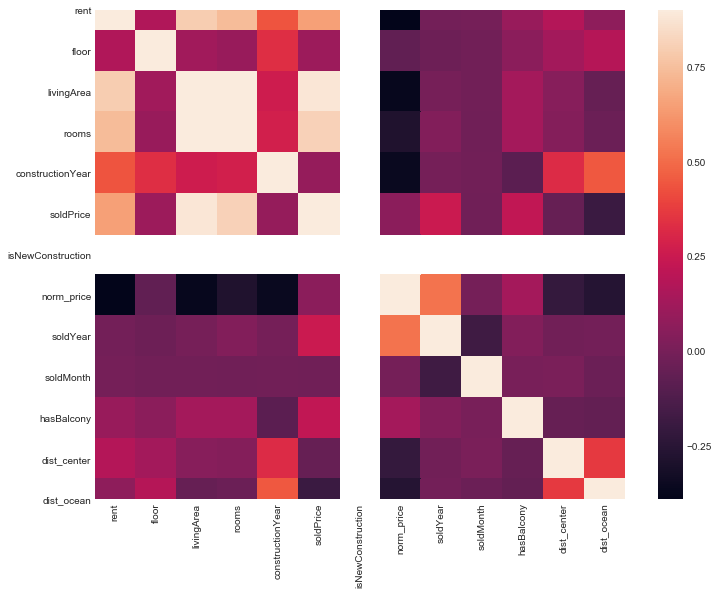

In [22]:
#Correlation map to see how features are correlated with SalePrice
corrmat = df_corr.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

# Deal with missing data


In [68]:
del_cols = ["additionalArea", "plotArea", 'isNewConstruction', 
            "booliId", "apartmentNumber", 'listPrice', 'price_increased', 'dist_ocean',
            "rent"]
ddf = df.drop(columns=del_cols)

def missing_data(tdf):
    total = ddf.isnull().sum().sort_values(ascending=False)
    percent = 100*(ddf.isnull().sum()/ddf.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data
    
missing_data(ddf).head(20)

,Total,Percent
constructionYear,412,10.745957
floor,381,9.937402
livingArea,10,0.260824
norm_price,10,0.260824
rooms,7,0.182577
dist_center,0,0.000000
soldPriceSource,0,0.000000
source,0,0.000000
published,0,0.000000
objectType,0,0.000000


In [69]:
#dealing with missing data
# we don't want to remove the floor feature since it makes some impact
# let's use the median
ddf['floor'] = ddf['floor'].replace(np.nan, ddf['floor'].median())
ddf['constructionYear'] = ddf['constructionYear'].replace(np.nan, ddf['constructionYear'].median())
ddf = ddf.drop(ddf.loc[ddf['rooms'].isnull()].index)
ddf = ddf.drop(ddf.loc[ddf['livingArea'].isnull()].index)
ddf = ddf.drop(ddf.loc[ddf['norm_price'].isnull()].index)


# remove outliers
ddf = ddf.drop(ddf.loc[ddf['floor'] > 20].index)

missing_data(ddf).head(20)
print("New data shape: {}".format(ddf.shape))

New data shape: (3820, 23)


## global pairplot

In [70]:
#cols = quantitative_vars + discrete_vars + ['soldPrice']
#sns.pairplot(ddf, vars=cols)

# In the search for normality

The point here is to test 'SalePrice' in a very lean way. We'll do this paying attention to:

    Histogram - Kurtosis and skewness.
    Normal probability plot - Data distribution should closely follow the diagonal that represents the normal distribution.


In [71]:
import scipy.stats as st

def is_normal(_df, _vars):
    test_normality = lambda x: stats.shapiro(x.fillna(0))[1] < 0.01
    normal = pd.DataFrame(_df[_vars])
    normal = normal.apply(test_normality)
    return not normal.any()

def plot_hist_prob(_df, var_test, transform=None):
    #histogram and normal probability plot
    if transform is None:
        transform = lambda x: x
    sns.distplot(_df[var_test].apply(transform), fit=norm);
    fig = plt.figure()
    res = stats.probplot(_df[var_test], plot=plt)
    
def check_dist_fit(_df, name):
    _y = _df[name].dropna()
    plt.figure(1); plt.title(name + ' Johnson SU')
    sns.distplot(_y, kde=False, fit=st.johnsonsu)
    plt.figure(2); plt.title(name + ' Normal')
    sns.distplot(_y, kde=False, fit=st.norm)
    plt.figure(3); plt.title(name + ' Log Normal')
    sns.distplot(_y, kde=False, fit=st.lognorm)

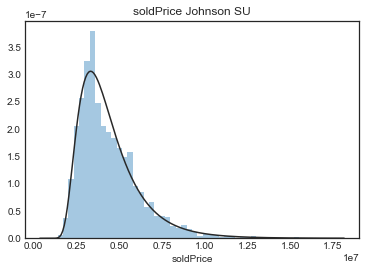

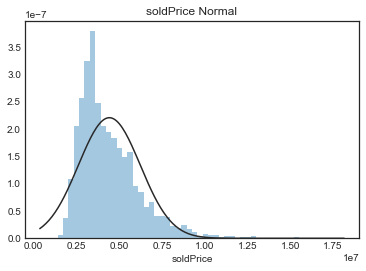

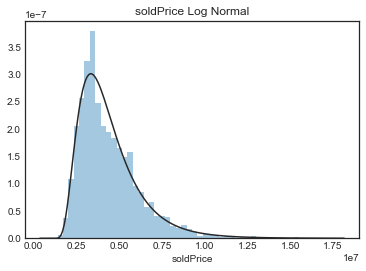

In [72]:
check_dist_fit(df, 'soldPrice')

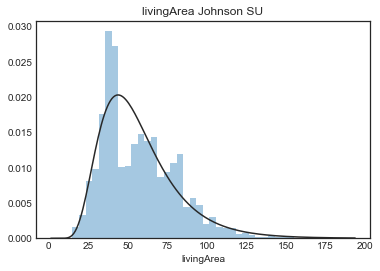

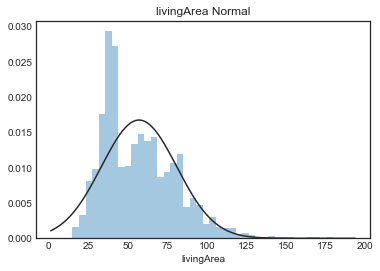

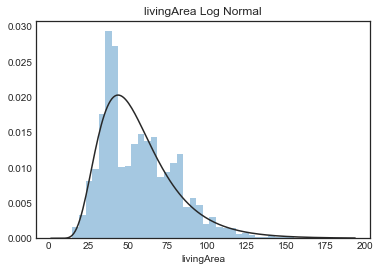

In [73]:
check_dist_fit(df, 'livingArea')

Target is not normal. Apply log_transform
Is normal after transformation? False


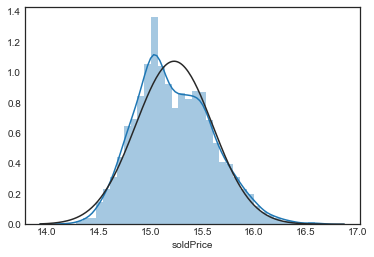

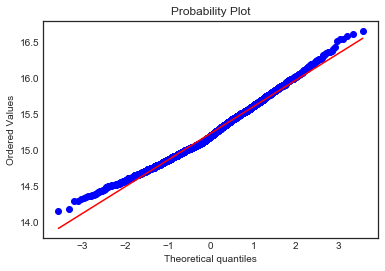

In [74]:
if not is_normal(ddf, ["soldPrice"]):
    print("Target is not normal. Apply log_transform")
    ddf["soldPrice"] = log_transform("soldPrice", ddf)
    plot_hist_prob(ddf, "soldPrice")

    print("Is normal after transformation? {}".format(is_normal(ddf, ["soldPrice"])))
else:
    print("Is normal? {}".format(is_normal(ddf, ["soldPrice"])))


Skewness: 0.981159
Kurtosis: 1.335920


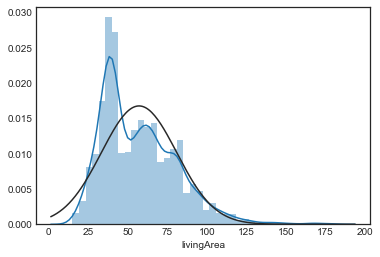

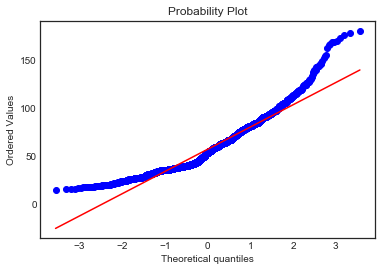

In [75]:
plot_hist_prob(ddf, "livingArea")
#skewness and kurtosis
print("Skewness: %f" % ddf['livingArea'].skew())
print("Kurtosis: %f" % ddf['livingArea'].kurt())

In [76]:
# Check the skew of all numerical features

skewed_feats = ddf[quantitative_vars].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
livingArea,0.980773


In [77]:
skewness = skewness[abs(skewness) > 0.75].dropna()
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))
from scipy.special import boxcox1p
skewed_features = skewness.index

#https://machinelearningmastery.com/how-to-transform-data-to-fit-the-normal-distribution/
#    lambda = -1. is a reciprocal transform.
#    lambda = -0.5 is a reciprocal square root transform.
#    lambda = 0.0 is a log transform.
#    lambda = 0.5 is a square root transform.
#    lambda = 1.0 is no transform.

ddfs = ddf.copy()

lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    print("apply to {}".format(feat))
    ddfs[feat] = boxcox1p(ddfs[feat], lam)

There are 1 skewed numerical features to Box Cox transform
apply to livingArea


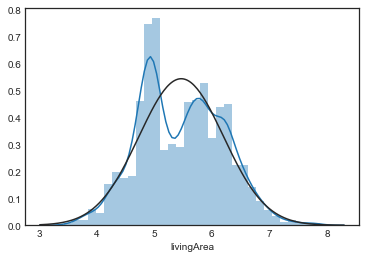

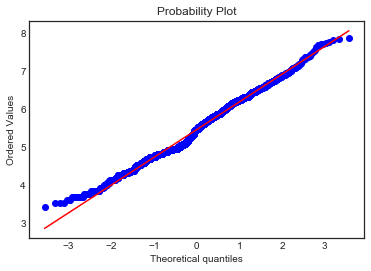

In [78]:
plot_hist_prob(ddfs, "livingArea")

# Build model

https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard

In [79]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, StandardScaler, OneHotEncoder

from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge

from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error

import xgboost as xgb
import lightgbm as lgb

## Prepare data for the model

In [80]:
# Divide our data into test/train
# create training and testing vars
# df: original data
# ddf: orginal data - nulls and outliers
# ddfs: orgininal with transform boxcop
# ddft: original data - null and outliers - log transform (on soldPrice)
x = ddfs.copy()
    
features = quantitative_vars + discrete_vars + boolean_vars + categorical_vars
feature_names = pd.Series(features)
target = "soldPrice"

y = x[target] # define the target variable (dependent variable) as y
x = x[feature_names]
print("Columns order: {}".format(x.columns))

# apply preprocessing to all
from sklearn.preprocessing import FunctionTransformer

# Apply scaler
numeric_transformer = Pipeline(steps=[('scaler', RobustScaler())])

# One hot encoder
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer( remainder='passthrough',
    transformers=[
        ('num', numeric_transformer, quantitative_vars),
        ('cat', categorical_transformer, categorical_vars)])

preprocessor_pipeline = Pipeline(steps=[('preprocessor', preprocessor), 
                                        ('todense', FunctionTransformer(lambda x: x.todense(), accept_sparse=True), )])
preprocessor_pipeline.fit(x)

x = preprocessor_pipeline.transform(x)
#dir(preprocessor_pipeline)

Columns order: Index(['livingArea', 'rooms', 'floor', 'soldYear', 'soldMonth',
       'constructionYear', 'hasBalcony', 'street_name', 'street_number'],
      dtype='object')


## Split data train/test

In [81]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
print("Train shapes: ", X_train.shape, y_train.shape)
print("Test shapes: ", X_test.shape, y_test.shape)
print("Features selected: {}".format(features))

Train shapes:  (3056, 249) (3056,)
Test shapes:  (764, 249) (764,)
Features selected: ['livingArea', 'rooms', 'floor', 'soldYear', 'soldMonth', 'constructionYear', 'hasBalcony', 'street_name', 'street_number']


## Regression methods
* Linear
* Logistic
* Polynomial
* ElasticNet
* Ridge
* Lasso
https://www.analyticsvidhya.com/blog/2015/08/comprehensive-guide-regression/
    
More regressors using scikit learn: 
    * https://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble
    * https://scikit-learn.org/stable/modules/classes.html#module-sklearn.kernel_ridge
    * https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model

In [95]:
# Perform the Kfold score analysis
KFOLD_SCORE=True
# Perform the Kfold for all models
ALL_MODELS_SCORE=True

# Fit all models
ALL_MODELS_FIT=True

# Perform the Grid Search on selected models
SELECTED_GRID_SEARCH=False

### Normalize data
https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02

### Base models

#### Linear regression models

In [96]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.kernel_ridge import KernelRidge

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


# ElasticNet
en = ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3)
#en.fit(X_train, y_train)

# Lasso
lassoIc = LassoLarsIC()
#lassoIc.fit(X_train, y_train)
                 
# Lasso
lasso = Lasso(alpha =0.0005, random_state=1)
#lasso.fit(X_train, y_train)

# BayesianRidge
ridge = BayesianRidge()
#ridge.fit(X_train, y_train)

# Kernel Ridge
krr = KernelRidge()
#krr.fit(X_train, y_train)


linear_models = {"ElasticNet": en, "LassoLarsIC": lassoIc, 
                 "Lasso": lasso, "BayesianRidge": ridge,
                 "KernelRidge": krr}

### Ensemble models

In [97]:
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor


# Random Forest
rfr = RandomForestRegressor(max_depth=4, random_state=0, n_estimators=600)
#rfr.fit(X_train, y_train)


# AdaBoost
rng = np.random.RandomState(1)
abr = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),
                                 n_estimators=300, random_state=rng)
#abr.fit(X_train, y_train)


# Gradient Boosting
params = {'n_estimators': 1000, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
gbr = GradientBoostingRegressor(**params)
#gbr.fit(X_train, y_train)


ensemble_models = {"RandomForestRegressor": rfr, 
                   "AdaBoostRegressor": abr, "GradientBoostingRegressor": gbr}

In [98]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import lightgbm as lgb

# XGBoosting

params = {'colsample_bytree': 0.9606895670866631, 
          'gamma': 0.026620140772716794, 
          'learning_rate': 0.11046030263179152, 
          'max_depth': 2, 'n_estimators': 253, 
          'subsample': 0.6179109168365381}
params.update({"objective": "reg:squarederror"})
xgb = XGBRegressor(**params)
#xgb.fit(X_train, y_train)
#evallist = [(dtest, 'eval'), (dtrain, 'train')]

# from GridCV search
params = {'learning_rate': 0.1, 'max_bin': 100, 'n_estimators': 2000, 'num_iterations': 200}
lgbr = LGBMRegressor(**params)
#lgbr.fit(X_train, y_train)


other_models = {"XGBoosting": xgb, "Lightgbm": lgbr}
selected_model = {"Lightgbm": lgbr, "XGBoosting": xgb}

all_models = {**linear_models, **ensemble_models, **other_models}

## Evaluate the models
* API: https://scikit-learn.org/stable/modules/classes.html#regression-metrics
* Doc: https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics

### Base model scores

In [99]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split

### Use cross-validation based on RMSLE
#Validation function
n_folds = 5

def kfold_default(dtrain, ytrain): 
    return KFold(n_folds, shuffle=True, random_state=42).get_n_splits(dtrain)
 
def rmsle_cv(model, dtrain, ytrain):
    kf = kfold_default(dtrain, ytrain)
    rmse= np.sqrt(-cross_val_score(model, dtrain, ytrain, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)
def print_score(name, regressor, X_test, y_test):
    print("{:>30} - score: {:>20}".format(name, regressor.score(X_test, y_test)))
def get_print_base_score(n, r, dtrain, ytrain):
    # apply preprocessing
    t0 = time.time()
    score = rmsle_cv(r, dtrain, ytrain)
    print("{:>30} score: {:.4f} ({:.4f}) in {} s".format(n, score.mean(), score.std(), time.time()-t0))
def print_metrics(name, y_true, y_pred):
    def printp(args): print("{:>30} - ".format(name)+args)
    printp("mean_absolute_error:      {:>30} (better 0)".format(metrics.mean_absolute_error(y_true, y_pred)))
    printp("mean_squared_error:       {:>30} (better 0)".format(metrics.mean_squared_error(y_true, y_pred)))
    printp("mean_squared_log_error:   {:>30} (better 0)".format(metrics.mean_squared_log_error(y_true, y_pred)))
    printp("median_absolute_error:    {:>30} (better 0)".format(metrics.median_absolute_error(y_true, y_pred)))
    
    printp("explained_variance_score: {:>30} (better 1)".format(metrics.explained_variance_score(y_true, y_pred)))
    printp("r2_score:                 {:>30} (better 1)".format(metrics.r2_score(y_true, y_pred)))

In [100]:
if KFOLD_SCORE and ALL_MODELS_SCORE:
    print("=================== Linear models (CV) ===================")
    for n, r in linear_models.items():
        get_print_base_score(n, r, X_train, y_train)

    print("=================== Ensemble models (CV) ===================")
    for n, r in ensemble_models.items():
        get_print_base_score(n, r, X_train, y_train)

    print("=================== Other models (CV) ===================")
    for n, r in other_models.items():
        get_print_base_score(n, r, X_train, y_train)
        
if KFOLD_SCORE and SELECTED_GRID_SEARCH:
    for n, r in selected_model.items():
        get_print_base_score(n, r, X_train, y_train)

=================== Linear models (CV) ===================
                    ElasticNet score: 0.1169 (0.0019) in 0.12475800514221191 s
                   LassoLarsIC score: 0.1227 (0.0035) in 0.8844764232635498 s
                         Lasso score: 0.1172 (0.0020) in 0.10600590705871582 s
                 BayesianRidge score: 0.1138 (0.0015) in 0.5698859691619873 s
                   KernelRidge score: 0.1474 (0.0036) in 2.77557635307312 s
=================== Ensemble models (CV) ===================
         RandomForestRegressor score: 0.1267 (0.0037) in 18.405799865722656 s
             AdaBoostRegressor score: 0.1075 (0.0030) in 17.023717641830444 s
     GradientBoostingRegressor score: 0.0873 (0.0016) in 88.21772456169128 s
=================== Other models (CV) ===================
                    XGBoosting score: 0.0867 (0.0024) in 10.786977052688599 s
                      Lightgbm score: 0.0842 (0.0013) in 0.7436099052429199 s


In [46]:
from scipy.stats import uniform, randint

if SELECTED_GRID_SEARCH:
    best_selected_model = {}
    # use GridSearchCV
    for n, r in selected_model.items():
        # https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html
        # For better accuracy
        # Use large max_bin (may be slower)
        # Use small learning_rate with large num_iterations
        # Use large num_leaves (may cause over-fitting)
        # Use bigger training data
        # Try dart

        # Important features: num_leaves, bins, feature_fraction, 
        #bagging_fraction, min_data_in_leaf, min_sum_hessian_in_leaf and few others.
        if "Lightgbm" in n:
            param_grid = {
                'learning_rate': [0.01, 0.1, 1],
                'n_estimators': [2000],
                'num_iterations': [200, 400],
                'max_bin': [10, 50, 100]
            }
        elif "XGBoosting" in n:
            param_grid = {
                "colsample_bytree": uniform(0.7, 0.3),
                "gamma": uniform(0, 0.5),
                "learning_rate": uniform(0.03, 0.3), # default 0.1 
                "max_depth": randint(2, 6), # default 3
                "n_estimators": randint(300, 700), # default 100
                "subsample": uniform(0.6, 0.4)
            }
        rcv = RandomizedSearchCV(r, param_grid, 
                                 cv=kfold_default(X_train, y_train),
                                 n_iter = 10, verbose=False)
        #rcv = GridSearchCV(r, param_grid, cv=kfold_default(X_train, y_train))
        rcv.fit(X_train, y_train)

        print('Best parameters found by grid search are:', rcv.best_params_)
        print('Best score found by grid search are:', rcv.best_score_)

        nn = n + "-grid"
        print_score(nn, rcv, X_test, y_test)

        best_selected_model.update({nn: rcv})

Best parameters found by grid search are: {'num_iterations': 200, 'n_estimators': 2000, 'max_bin': 50, 'learning_rate': 0.1}
Best score found by grid search are: 0.9486837788517868
                 Lightgbm-grid - score:    0.949377425256539
[0]	validation_0-rmse:14.2557
[1]	validation_0-rmse:13.7945
[2]	validation_0-rmse:13.3483
[3]	validation_0-rmse:12.9166
[4]	validation_0-rmse:12.4988
[5]	validation_0-rmse:12.0947
[6]	validation_0-rmse:11.7036
[7]	validation_0-rmse:11.3252
[8]	validation_0-rmse:10.959
[9]	validation_0-rmse:10.6046
[10]	validation_0-rmse:10.2616
[11]	validation_0-rmse:9.92978
[12]	validation_0-rmse:9.60864
[13]	validation_0-rmse:9.29805
[14]	validation_0-rmse:8.99742
[15]	validation_0-rmse:8.70655
[16]	validation_0-rmse:8.42503
[17]	validation_0-rmse:8.15266
[18]	validation_0-rmse:7.88909
[19]	validation_0-rmse:7.63406
[20]	validation_0-rmse:7.38719
[21]	validation_0-rmse:7.14838
[22]	validation_0-rmse:6.91736
[23]	validation_0-rmse:6.69404
[24]	validation_0-rmse:6.

[248]	validation_0-rmse:0.094772
[249]	validation_0-rmse:0.094719
[250]	validation_0-rmse:0.094629
[251]	validation_0-rmse:0.094553
[252]	validation_0-rmse:0.094469
[253]	validation_0-rmse:0.094393
[254]	validation_0-rmse:0.094244
[255]	validation_0-rmse:0.094198
[256]	validation_0-rmse:0.094132
[257]	validation_0-rmse:0.094057
[258]	validation_0-rmse:0.094013
[259]	validation_0-rmse:0.093938
[260]	validation_0-rmse:0.093866
[261]	validation_0-rmse:0.093818
[262]	validation_0-rmse:0.093753
[263]	validation_0-rmse:0.093726
[264]	validation_0-rmse:0.093672
[265]	validation_0-rmse:0.093596
[266]	validation_0-rmse:0.093549
[267]	validation_0-rmse:0.093495
[268]	validation_0-rmse:0.093458
[269]	validation_0-rmse:0.093394
[270]	validation_0-rmse:0.093315
[271]	validation_0-rmse:0.093252
[272]	validation_0-rmse:0.093209
[273]	validation_0-rmse:0.093133
[274]	validation_0-rmse:0.093077
[275]	validation_0-rmse:0.093032
[276]	validation_0-rmse:0.092982
[277]	validation_0-rmse:0.09294
[278]	valid

[177]	validation_0-rmse:0.109668
[178]	validation_0-rmse:0.108991
[179]	validation_0-rmse:0.108418
[180]	validation_0-rmse:0.107813
[181]	validation_0-rmse:0.107274
[182]	validation_0-rmse:0.10675
[183]	validation_0-rmse:0.106241
[184]	validation_0-rmse:0.105751
[185]	validation_0-rmse:0.105295
[186]	validation_0-rmse:0.104837
[187]	validation_0-rmse:0.10437
[188]	validation_0-rmse:0.103925
[189]	validation_0-rmse:0.10356
[190]	validation_0-rmse:0.103224
[191]	validation_0-rmse:0.102889
[192]	validation_0-rmse:0.102543
[193]	validation_0-rmse:0.102203
[194]	validation_0-rmse:0.101922
[195]	validation_0-rmse:0.101619
[196]	validation_0-rmse:0.101361
[197]	validation_0-rmse:0.101096
[198]	validation_0-rmse:0.100841
[199]	validation_0-rmse:0.100596
[200]	validation_0-rmse:0.100363
[201]	validation_0-rmse:0.100189
[202]	validation_0-rmse:0.099938
[203]	validation_0-rmse:0.099744
[204]	validation_0-rmse:0.099479
[205]	validation_0-rmse:0.099296
[206]	validation_0-rmse:0.099137
[207]	validat

[106]	validation_0-rmse:0.456861
[107]	validation_0-rmse:0.443197
[108]	validation_0-rmse:0.429878
[109]	validation_0-rmse:0.417031
[110]	validation_0-rmse:0.40472
[111]	validation_0-rmse:0.392715
[112]	validation_0-rmse:0.381261
[113]	validation_0-rmse:0.370171
[114]	validation_0-rmse:0.359371
[115]	validation_0-rmse:0.348942
[116]	validation_0-rmse:0.338913
[117]	validation_0-rmse:0.329258
[118]	validation_0-rmse:0.319897
[119]	validation_0-rmse:0.310899
[120]	validation_0-rmse:0.302286
[121]	validation_0-rmse:0.293893
[122]	validation_0-rmse:0.285754
[123]	validation_0-rmse:0.278011
[124]	validation_0-rmse:0.270504
[125]	validation_0-rmse:0.263236
[126]	validation_0-rmse:0.256383
[127]	validation_0-rmse:0.249672
[128]	validation_0-rmse:0.24321
[129]	validation_0-rmse:0.236889
[130]	validation_0-rmse:0.230911
[131]	validation_0-rmse:0.225168
[132]	validation_0-rmse:0.219656
[133]	validation_0-rmse:0.214309
[134]	validation_0-rmse:0.209148
[135]	validation_0-rmse:0.204175
[136]	valida

[32]	validation_0-rmse:4.98036
[33]	validation_0-rmse:4.81952
[34]	validation_0-rmse:4.66375
[35]	validation_0-rmse:4.51302
[36]	validation_0-rmse:4.36725
[37]	validation_0-rmse:4.22639
[38]	validation_0-rmse:4.08994
[39]	validation_0-rmse:3.95798
[40]	validation_0-rmse:3.83022
[41]	validation_0-rmse:3.70647
[42]	validation_0-rmse:3.58677
[43]	validation_0-rmse:3.47113
[44]	validation_0-rmse:3.35919
[45]	validation_0-rmse:3.25079
[46]	validation_0-rmse:3.14589
[47]	validation_0-rmse:3.04434
[48]	validation_0-rmse:2.94619
[49]	validation_0-rmse:2.85098
[50]	validation_0-rmse:2.75924
[51]	validation_0-rmse:2.67032
[52]	validation_0-rmse:2.58424
[53]	validation_0-rmse:2.50088
[54]	validation_0-rmse:2.42037
[55]	validation_0-rmse:2.34235
[56]	validation_0-rmse:2.26689
[57]	validation_0-rmse:2.19387
[58]	validation_0-rmse:2.12312
[59]	validation_0-rmse:2.05465
[60]	validation_0-rmse:1.98856
[61]	validation_0-rmse:1.92463
[62]	validation_0-rmse:1.86272
[63]	validation_0-rmse:1.80297
[64]	val

[285]	validation_0-rmse:0.093332
[286]	validation_0-rmse:0.093264
[287]	validation_0-rmse:0.093212
[288]	validation_0-rmse:0.093171
[289]	validation_0-rmse:0.093173
[290]	validation_0-rmse:0.093172
[291]	validation_0-rmse:0.093144
[292]	validation_0-rmse:0.093086
[293]	validation_0-rmse:0.093045
[294]	validation_0-rmse:0.093044
[295]	validation_0-rmse:0.093
[296]	validation_0-rmse:0.093
[297]	validation_0-rmse:0.092952
[298]	validation_0-rmse:0.092932
[299]	validation_0-rmse:0.092931
[300]	validation_0-rmse:0.092884
[301]	validation_0-rmse:0.092816
[302]	validation_0-rmse:0.092777
[303]	validation_0-rmse:0.092776
[304]	validation_0-rmse:0.092736
[305]	validation_0-rmse:0.092736
[306]	validation_0-rmse:0.092735
[307]	validation_0-rmse:0.092735
[308]	validation_0-rmse:0.092735
[309]	validation_0-rmse:0.092716
[310]	validation_0-rmse:0.092673
[311]	validation_0-rmse:0.092646
[312]	validation_0-rmse:0.092646
[313]	validation_0-rmse:0.092616
[314]	validation_0-rmse:0.092615
[315]	validation

[215]	validation_0-rmse:0.099231
[216]	validation_0-rmse:0.099097
[217]	validation_0-rmse:0.098988
[218]	validation_0-rmse:0.098836
[219]	validation_0-rmse:0.098652
[220]	validation_0-rmse:0.098542
[221]	validation_0-rmse:0.098397
[222]	validation_0-rmse:0.098255
[223]	validation_0-rmse:0.098106
[224]	validation_0-rmse:0.098
[225]	validation_0-rmse:0.097895
[226]	validation_0-rmse:0.0978
[227]	validation_0-rmse:0.097698
[228]	validation_0-rmse:0.097603
[229]	validation_0-rmse:0.09749
[230]	validation_0-rmse:0.0974
[231]	validation_0-rmse:0.097328
[232]	validation_0-rmse:0.097261
[233]	validation_0-rmse:0.097142
[234]	validation_0-rmse:0.097041
[235]	validation_0-rmse:0.096924
[236]	validation_0-rmse:0.096823
[237]	validation_0-rmse:0.096728
[238]	validation_0-rmse:0.09665
[239]	validation_0-rmse:0.096547
[240]	validation_0-rmse:0.096509
[241]	validation_0-rmse:0.096457
[242]	validation_0-rmse:0.096394
[243]	validation_0-rmse:0.096317
[244]	validation_0-rmse:0.096228
[245]	validation_0-

[142]	validation_0-rmse:0.096476
[143]	validation_0-rmse:0.096477
[144]	validation_0-rmse:0.096477
[145]	validation_0-rmse:0.096486
[146]	validation_0-rmse:0.096479
[147]	validation_0-rmse:0.096477
[148]	validation_0-rmse:0.096474
[149]	validation_0-rmse:0.096475
[150]	validation_0-rmse:0.096473
[151]	validation_0-rmse:0.09647
[152]	validation_0-rmse:0.096471
[153]	validation_0-rmse:0.096474
[154]	validation_0-rmse:0.096477
[155]	validation_0-rmse:0.096475
[156]	validation_0-rmse:0.096477
[157]	validation_0-rmse:0.096477
[158]	validation_0-rmse:0.096479
[159]	validation_0-rmse:0.096485
[160]	validation_0-rmse:0.096478
[161]	validation_0-rmse:0.09648
[162]	validation_0-rmse:0.09648
[163]	validation_0-rmse:0.096489
[164]	validation_0-rmse:0.096479
[165]	validation_0-rmse:0.096478
[166]	validation_0-rmse:0.096477
[167]	validation_0-rmse:0.096482
[168]	validation_0-rmse:0.096483
[169]	validation_0-rmse:0.096475
[170]	validation_0-rmse:0.096481
[171]	validation_0-rmse:0.096478
[172]	validat

[0]	validation_0-rmse:10.279
[1]	validation_0-rmse:7.17254
[2]	validation_0-rmse:5.00608
[3]	validation_0-rmse:3.49443
[4]	validation_0-rmse:2.44045
[5]	validation_0-rmse:1.70699
[6]	validation_0-rmse:1.19444
[7]	validation_0-rmse:0.838505
[8]	validation_0-rmse:0.592239
[9]	validation_0-rmse:0.421231
[10]	validation_0-rmse:0.305878
[11]	validation_0-rmse:0.2279
[12]	validation_0-rmse:0.178024
[13]	validation_0-rmse:0.145791
[14]	validation_0-rmse:0.125982
[15]	validation_0-rmse:0.115037
[16]	validation_0-rmse:0.108573
[17]	validation_0-rmse:0.104836
[18]	validation_0-rmse:0.102575
[19]	validation_0-rmse:0.101057
[20]	validation_0-rmse:0.099897
[21]	validation_0-rmse:0.099284
[22]	validation_0-rmse:0.098035
[23]	validation_0-rmse:0.097098
[24]	validation_0-rmse:0.096627
[25]	validation_0-rmse:0.096565
[26]	validation_0-rmse:0.096085
[27]	validation_0-rmse:0.09592
[28]	validation_0-rmse:0.095909
[29]	validation_0-rmse:0.095396
[30]	validation_0-rmse:0.094665
[31]	validation_0-rmse:0.0946

[253]	validation_0-rmse:0.092915
[254]	validation_0-rmse:0.092915
[255]	validation_0-rmse:0.092915
[256]	validation_0-rmse:0.092915
[257]	validation_0-rmse:0.092912
[258]	validation_0-rmse:0.092907
[259]	validation_0-rmse:0.092914
[260]	validation_0-rmse:0.09292
[261]	validation_0-rmse:0.092919
[262]	validation_0-rmse:0.092919
[263]	validation_0-rmse:0.09292
[264]	validation_0-rmse:0.092914
[265]	validation_0-rmse:0.09292
[266]	validation_0-rmse:0.092922
[267]	validation_0-rmse:0.092923
[268]	validation_0-rmse:0.092926
[269]	validation_0-rmse:0.092931
[270]	validation_0-rmse:0.092929
[271]	validation_0-rmse:0.092923
[272]	validation_0-rmse:0.09293
[273]	validation_0-rmse:0.092923
[274]	validation_0-rmse:0.092917
[275]	validation_0-rmse:0.092917
[276]	validation_0-rmse:0.092914
[277]	validation_0-rmse:0.092917
[278]	validation_0-rmse:0.092913
[279]	validation_0-rmse:0.092916
[280]	validation_0-rmse:0.092921
[281]	validation_0-rmse:0.092921
[282]	validation_0-rmse:0.092926
[283]	validati

[115]	validation_0-rmse:0.093596
[116]	validation_0-rmse:0.093598
[117]	validation_0-rmse:0.093593
[118]	validation_0-rmse:0.093594
[119]	validation_0-rmse:0.093599
[120]	validation_0-rmse:0.093595
[121]	validation_0-rmse:0.093601
[122]	validation_0-rmse:0.093597
[123]	validation_0-rmse:0.093594
[124]	validation_0-rmse:0.093594
[125]	validation_0-rmse:0.093608
[126]	validation_0-rmse:0.093617
[127]	validation_0-rmse:0.093602
[128]	validation_0-rmse:0.093609
[129]	validation_0-rmse:0.093601
[130]	validation_0-rmse:0.093599
[131]	validation_0-rmse:0.093594
[132]	validation_0-rmse:0.093584
[133]	validation_0-rmse:0.09358
[134]	validation_0-rmse:0.093582
[135]	validation_0-rmse:0.093581
[136]	validation_0-rmse:0.093578
[137]	validation_0-rmse:0.093584
[138]	validation_0-rmse:0.093593
[139]	validation_0-rmse:0.093587
[140]	validation_0-rmse:0.093578
[141]	validation_0-rmse:0.093582
[142]	validation_0-rmse:0.09359
[143]	validation_0-rmse:0.093598
[144]	validation_0-rmse:0.093589
[145]	valida

[365]	validation_0-rmse:0.093228
[366]	validation_0-rmse:0.093235
[367]	validation_0-rmse:0.093247
[368]	validation_0-rmse:0.093259
[369]	validation_0-rmse:0.093248
[370]	validation_0-rmse:0.093244
[371]	validation_0-rmse:0.093244
[372]	validation_0-rmse:0.093243
[373]	validation_0-rmse:0.09324
[374]	validation_0-rmse:0.093238
[375]	validation_0-rmse:0.093244
[376]	validation_0-rmse:0.093252
[377]	validation_0-rmse:0.093253
[378]	validation_0-rmse:0.093242
[379]	validation_0-rmse:0.093236
[380]	validation_0-rmse:0.093242
[381]	validation_0-rmse:0.093243
[382]	validation_0-rmse:0.09324
[383]	validation_0-rmse:0.093233
[384]	validation_0-rmse:0.093238
[385]	validation_0-rmse:0.093236
[386]	validation_0-rmse:0.093231
[387]	validation_0-rmse:0.093243
[388]	validation_0-rmse:0.09324
[389]	validation_0-rmse:0.093242
[390]	validation_0-rmse:0.093243
[0]	validation_0-rmse:10.276
[1]	validation_0-rmse:7.1693
[2]	validation_0-rmse:5.0035
[3]	validation_0-rmse:3.49087
[4]	validation_0-rmse:2.4387

[227]	validation_0-rmse:0.095349
[228]	validation_0-rmse:0.095353
[229]	validation_0-rmse:0.095352
[230]	validation_0-rmse:0.095363
[231]	validation_0-rmse:0.095364
[232]	validation_0-rmse:0.095367
[233]	validation_0-rmse:0.095361
[234]	validation_0-rmse:0.095353
[235]	validation_0-rmse:0.095347
[236]	validation_0-rmse:0.095345
[237]	validation_0-rmse:0.095343
[238]	validation_0-rmse:0.095346
[239]	validation_0-rmse:0.095351
[240]	validation_0-rmse:0.095356
[241]	validation_0-rmse:0.09536
[242]	validation_0-rmse:0.095362
[243]	validation_0-rmse:0.095366
[244]	validation_0-rmse:0.095363
[245]	validation_0-rmse:0.095357
[246]	validation_0-rmse:0.095354
[247]	validation_0-rmse:0.095357
[248]	validation_0-rmse:0.095344
[249]	validation_0-rmse:0.09512
[250]	validation_0-rmse:0.095117
[251]	validation_0-rmse:0.095125
[252]	validation_0-rmse:0.095125
[253]	validation_0-rmse:0.095127
[254]	validation_0-rmse:0.09513
[255]	validation_0-rmse:0.095131
[256]	validation_0-rmse:0.095128
[257]	validat

[89]	validation_0-rmse:0.099187
[90]	validation_0-rmse:0.099187
[91]	validation_0-rmse:0.099185
[92]	validation_0-rmse:0.099184
[93]	validation_0-rmse:0.099188
[94]	validation_0-rmse:0.099185
[95]	validation_0-rmse:0.099184
[96]	validation_0-rmse:0.099186
[97]	validation_0-rmse:0.099185
[98]	validation_0-rmse:0.099181
[99]	validation_0-rmse:0.099181
[100]	validation_0-rmse:0.099184
[101]	validation_0-rmse:0.099183
[102]	validation_0-rmse:0.099185
[103]	validation_0-rmse:0.099185
[104]	validation_0-rmse:0.099189
[105]	validation_0-rmse:0.099191
[106]	validation_0-rmse:0.099196
[107]	validation_0-rmse:0.099192
[108]	validation_0-rmse:0.099187
[109]	validation_0-rmse:0.099187
[110]	validation_0-rmse:0.099186
[111]	validation_0-rmse:0.099187
[112]	validation_0-rmse:0.099189
[113]	validation_0-rmse:0.099188
[114]	validation_0-rmse:0.099188
[115]	validation_0-rmse:0.099189
[116]	validation_0-rmse:0.099189
[117]	validation_0-rmse:0.099186
[118]	validation_0-rmse:0.099186
[119]	validation_0-rm

[339]	validation_0-rmse:0.097982
[340]	validation_0-rmse:0.097981
[341]	validation_0-rmse:0.09798
[342]	validation_0-rmse:0.09798
[343]	validation_0-rmse:0.097979
[344]	validation_0-rmse:0.09798
[345]	validation_0-rmse:0.097984
[346]	validation_0-rmse:0.097989
[347]	validation_0-rmse:0.097985
[348]	validation_0-rmse:0.097981
[349]	validation_0-rmse:0.097986
[350]	validation_0-rmse:0.097989
[351]	validation_0-rmse:0.097988
[352]	validation_0-rmse:0.09798
[353]	validation_0-rmse:0.097981
[354]	validation_0-rmse:0.09798
[355]	validation_0-rmse:0.097979
[356]	validation_0-rmse:0.097981
[357]	validation_0-rmse:0.097982
[358]	validation_0-rmse:0.097981
[359]	validation_0-rmse:0.097982
[360]	validation_0-rmse:0.097984
[361]	validation_0-rmse:0.09798
[362]	validation_0-rmse:0.097978
[363]	validation_0-rmse:0.097978
[364]	validation_0-rmse:0.097979
[365]	validation_0-rmse:0.097981
[366]	validation_0-rmse:0.09798
[367]	validation_0-rmse:0.09798
[368]	validation_0-rmse:0.097989
[369]	validation_0

[202]	validation_0-rmse:0.090616
[203]	validation_0-rmse:0.090616
[204]	validation_0-rmse:0.090616
[205]	validation_0-rmse:0.090616
[206]	validation_0-rmse:0.090616
[207]	validation_0-rmse:0.090616
[208]	validation_0-rmse:0.090486
[209]	validation_0-rmse:0.090486
[210]	validation_0-rmse:0.090486
[211]	validation_0-rmse:0.090486
[212]	validation_0-rmse:0.090486
[213]	validation_0-rmse:0.090486
[214]	validation_0-rmse:0.090486
[215]	validation_0-rmse:0.090486
[216]	validation_0-rmse:0.090478
[217]	validation_0-rmse:0.090478
[218]	validation_0-rmse:0.090478
[219]	validation_0-rmse:0.090478
[220]	validation_0-rmse:0.090478
[221]	validation_0-rmse:0.090353
[0]	validation_0-rmse:12.6573
[1]	validation_0-rmse:10.875
[2]	validation_0-rmse:9.34409
[3]	validation_0-rmse:8.02773
[4]	validation_0-rmse:6.89739
[5]	validation_0-rmse:5.92709
[6]	validation_0-rmse:5.09323
[7]	validation_0-rmse:4.37804
[8]	validation_0-rmse:3.76192
[9]	validation_0-rmse:3.23363
[10]	validation_0-rmse:2.77875
[11]	valid

[12]	validation_0-rmse:2.05565
[13]	validation_0-rmse:1.76887
[14]	validation_0-rmse:1.52156
[15]	validation_0-rmse:1.31034
[16]	validation_0-rmse:1.12839
[17]	validation_0-rmse:0.9727
[18]	validation_0-rmse:0.839379
[19]	validation_0-rmse:0.725153
[20]	validation_0-rmse:0.627092
[21]	validation_0-rmse:0.54311
[22]	validation_0-rmse:0.472108
[23]	validation_0-rmse:0.410773
[24]	validation_0-rmse:0.359387
[25]	validation_0-rmse:0.315565
[26]	validation_0-rmse:0.278639
[27]	validation_0-rmse:0.2472
[28]	validation_0-rmse:0.221409
[29]	validation_0-rmse:0.200351
[30]	validation_0-rmse:0.18236
[31]	validation_0-rmse:0.167606
[32]	validation_0-rmse:0.155491
[33]	validation_0-rmse:0.145674
[34]	validation_0-rmse:0.138118
[35]	validation_0-rmse:0.13164
[36]	validation_0-rmse:0.126412
[37]	validation_0-rmse:0.122446
[38]	validation_0-rmse:0.118926
[39]	validation_0-rmse:0.116553
[40]	validation_0-rmse:0.114472
[41]	validation_0-rmse:0.112687
[42]	validation_0-rmse:0.111263
[43]	validation_0-rm

[45]	validation_0-rmse:0.107705
[46]	validation_0-rmse:0.106921
[47]	validation_0-rmse:0.106183
[48]	validation_0-rmse:0.10558
[49]	validation_0-rmse:0.104781
[50]	validation_0-rmse:0.10426
[51]	validation_0-rmse:0.103781
[52]	validation_0-rmse:0.103342
[53]	validation_0-rmse:0.102904
[54]	validation_0-rmse:0.102711
[55]	validation_0-rmse:0.102311
[56]	validation_0-rmse:0.101848
[57]	validation_0-rmse:0.101602
[58]	validation_0-rmse:0.101194
[59]	validation_0-rmse:0.100802
[60]	validation_0-rmse:0.100601
[61]	validation_0-rmse:0.09997
[62]	validation_0-rmse:0.099547
[63]	validation_0-rmse:0.099328
[64]	validation_0-rmse:0.098895
[65]	validation_0-rmse:0.098599
[66]	validation_0-rmse:0.098264
[67]	validation_0-rmse:0.098036
[68]	validation_0-rmse:0.097862
[69]	validation_0-rmse:0.097561
[70]	validation_0-rmse:0.097063
[71]	validation_0-rmse:0.096776
[72]	validation_0-rmse:0.096522
[73]	validation_0-rmse:0.096297
[74]	validation_0-rmse:0.09615
[75]	validation_0-rmse:0.096053
[76]	validat

[78]	validation_0-rmse:0.095695
[79]	validation_0-rmse:0.095535
[80]	validation_0-rmse:0.095399
[81]	validation_0-rmse:0.09539
[82]	validation_0-rmse:0.095259
[83]	validation_0-rmse:0.095052
[84]	validation_0-rmse:0.094859
[85]	validation_0-rmse:0.094659
[86]	validation_0-rmse:0.094557
[87]	validation_0-rmse:0.094489
[88]	validation_0-rmse:0.094509
[89]	validation_0-rmse:0.094321
[90]	validation_0-rmse:0.094197
[91]	validation_0-rmse:0.094119
[92]	validation_0-rmse:0.094018
[93]	validation_0-rmse:0.093838
[94]	validation_0-rmse:0.093706
[95]	validation_0-rmse:0.093591
[96]	validation_0-rmse:0.093511
[97]	validation_0-rmse:0.093391
[98]	validation_0-rmse:0.093306
[99]	validation_0-rmse:0.09329
[100]	validation_0-rmse:0.093201
[101]	validation_0-rmse:0.093131
[102]	validation_0-rmse:0.092994
[103]	validation_0-rmse:0.092773
[104]	validation_0-rmse:0.092728
[105]	validation_0-rmse:0.092729
[106]	validation_0-rmse:0.092692
[107]	validation_0-rmse:0.092611
[108]	validation_0-rmse:0.092609
[

[110]	validation_0-rmse:0.094643
[111]	validation_0-rmse:0.094644
[112]	validation_0-rmse:0.094645
[113]	validation_0-rmse:0.094645
[114]	validation_0-rmse:0.094645
[115]	validation_0-rmse:0.094644
[116]	validation_0-rmse:0.094643
[117]	validation_0-rmse:0.094643
[118]	validation_0-rmse:0.094644
[119]	validation_0-rmse:0.094645
[120]	validation_0-rmse:0.094644
[121]	validation_0-rmse:0.094644
[122]	validation_0-rmse:0.094644
[123]	validation_0-rmse:0.094644
[124]	validation_0-rmse:0.094643
[125]	validation_0-rmse:0.094643
[126]	validation_0-rmse:0.094644
[127]	validation_0-rmse:0.094643
[128]	validation_0-rmse:0.094644
[129]	validation_0-rmse:0.094643
[130]	validation_0-rmse:0.094643
[131]	validation_0-rmse:0.094643
[132]	validation_0-rmse:0.094643
[133]	validation_0-rmse:0.094643
[134]	validation_0-rmse:0.094643
[135]	validation_0-rmse:0.094643
[136]	validation_0-rmse:0.094643
[137]	validation_0-rmse:0.094643
[138]	validation_0-rmse:0.094643
[139]	validation_0-rmse:0.094643
[140]	vali

[361]	validation_0-rmse:0.093122
[362]	validation_0-rmse:0.093122
[363]	validation_0-rmse:0.093122
[364]	validation_0-rmse:0.093122
[365]	validation_0-rmse:0.093122
[366]	validation_0-rmse:0.093122
[367]	validation_0-rmse:0.093123
[368]	validation_0-rmse:0.093123
[369]	validation_0-rmse:0.093122
[370]	validation_0-rmse:0.093122
[371]	validation_0-rmse:0.093122
[372]	validation_0-rmse:0.093122
[373]	validation_0-rmse:0.093124
[374]	validation_0-rmse:0.093123
[375]	validation_0-rmse:0.093124
[376]	validation_0-rmse:0.093125
[377]	validation_0-rmse:0.093125
[378]	validation_0-rmse:0.093126
[379]	validation_0-rmse:0.093125
[380]	validation_0-rmse:0.093123
[381]	validation_0-rmse:0.093123
[382]	validation_0-rmse:0.093123
[383]	validation_0-rmse:0.093123
[384]	validation_0-rmse:0.093122
[385]	validation_0-rmse:0.093122
[386]	validation_0-rmse:0.093122
[387]	validation_0-rmse:0.093122
[388]	validation_0-rmse:0.093122
[389]	validation_0-rmse:0.093122
[390]	validation_0-rmse:0.093122
[391]	vali

[26]	validation_0-rmse:0.100639
[27]	validation_0-rmse:0.099655
[28]	validation_0-rmse:0.098754
[29]	validation_0-rmse:0.097947
[30]	validation_0-rmse:0.097406
[31]	validation_0-rmse:0.096542
[32]	validation_0-rmse:0.095995
[33]	validation_0-rmse:0.095452
[34]	validation_0-rmse:0.095013
[35]	validation_0-rmse:0.094387
[36]	validation_0-rmse:0.094383
[37]	validation_0-rmse:0.094381
[38]	validation_0-rmse:0.094378
[39]	validation_0-rmse:0.094007
[40]	validation_0-rmse:0.094
[41]	validation_0-rmse:0.093589
[42]	validation_0-rmse:0.092736
[43]	validation_0-rmse:0.092704
[44]	validation_0-rmse:0.092706
[45]	validation_0-rmse:0.092714
[46]	validation_0-rmse:0.092431
[47]	validation_0-rmse:0.092428
[48]	validation_0-rmse:0.092426
[49]	validation_0-rmse:0.092159
[50]	validation_0-rmse:0.091745
[51]	validation_0-rmse:0.091745
[52]	validation_0-rmse:0.091646
[53]	validation_0-rmse:0.091724
[54]	validation_0-rmse:0.091727
[55]	validation_0-rmse:0.091728
[56]	validation_0-rmse:0.091731
[57]	valida

[278]	validation_0-rmse:0.091161
[279]	validation_0-rmse:0.091162
[280]	validation_0-rmse:0.091166
[281]	validation_0-rmse:0.091163
[282]	validation_0-rmse:0.091167
[283]	validation_0-rmse:0.091166
[284]	validation_0-rmse:0.091166
[285]	validation_0-rmse:0.091165
[286]	validation_0-rmse:0.091169
[287]	validation_0-rmse:0.091166
[288]	validation_0-rmse:0.091171
[289]	validation_0-rmse:0.091169
[290]	validation_0-rmse:0.091167
[291]	validation_0-rmse:0.091168
[292]	validation_0-rmse:0.091168
[293]	validation_0-rmse:0.09117
[294]	validation_0-rmse:0.091168
[295]	validation_0-rmse:0.091167
[296]	validation_0-rmse:0.091165
[297]	validation_0-rmse:0.091164
[298]	validation_0-rmse:0.091163
[299]	validation_0-rmse:0.091163
[300]	validation_0-rmse:0.09117
[301]	validation_0-rmse:0.091169
[302]	validation_0-rmse:0.09117
[303]	validation_0-rmse:0.091167
[304]	validation_0-rmse:0.091167
[305]	validation_0-rmse:0.091164
[306]	validation_0-rmse:0.091167
[307]	validation_0-rmse:0.091165
[308]	validat

[527]	validation_0-rmse:0.090896
[528]	validation_0-rmse:0.090898
[529]	validation_0-rmse:0.090895
[530]	validation_0-rmse:0.090893
[531]	validation_0-rmse:0.090898
[532]	validation_0-rmse:0.090896
[533]	validation_0-rmse:0.090896
[534]	validation_0-rmse:0.090904
[535]	validation_0-rmse:0.090907
[536]	validation_0-rmse:0.090908
[537]	validation_0-rmse:0.090908
[538]	validation_0-rmse:0.090906
[539]	validation_0-rmse:0.090897
[540]	validation_0-rmse:0.090897
[541]	validation_0-rmse:0.090896
[542]	validation_0-rmse:0.090893
[543]	validation_0-rmse:0.090894
[544]	validation_0-rmse:0.09089
[545]	validation_0-rmse:0.090892
[546]	validation_0-rmse:0.090891
[547]	validation_0-rmse:0.09089
[548]	validation_0-rmse:0.090891
[549]	validation_0-rmse:0.090894
[550]	validation_0-rmse:0.090894
[551]	validation_0-rmse:0.090893
[552]	validation_0-rmse:0.09089
[553]	validation_0-rmse:0.090894
[554]	validation_0-rmse:0.090892
[555]	validation_0-rmse:0.090892
[556]	validation_0-rmse:0.09089
[557]	validati

[195]	validation_0-rmse:0.092826
[196]	validation_0-rmse:0.092824
[197]	validation_0-rmse:0.092825
[198]	validation_0-rmse:0.092829
[199]	validation_0-rmse:0.092833
[200]	validation_0-rmse:0.092829
[201]	validation_0-rmse:0.092825
[202]	validation_0-rmse:0.092823
[203]	validation_0-rmse:0.092822
[204]	validation_0-rmse:0.092826
[205]	validation_0-rmse:0.092831
[206]	validation_0-rmse:0.092833
[207]	validation_0-rmse:0.092837
[208]	validation_0-rmse:0.092837
[209]	validation_0-rmse:0.092833
[210]	validation_0-rmse:0.092835
[211]	validation_0-rmse:0.09284
[212]	validation_0-rmse:0.092842
[213]	validation_0-rmse:0.09284
[214]	validation_0-rmse:0.092831
[215]	validation_0-rmse:0.09283
[216]	validation_0-rmse:0.092834
[217]	validation_0-rmse:0.09283
[218]	validation_0-rmse:0.09283
[219]	validation_0-rmse:0.092833
[220]	validation_0-rmse:0.092833
[221]	validation_0-rmse:0.092834
[222]	validation_0-rmse:0.092833
[223]	validation_0-rmse:0.092829
[224]	validation_0-rmse:0.092832
[225]	validatio

[444]	validation_0-rmse:0.091981
[445]	validation_0-rmse:0.091982
[446]	validation_0-rmse:0.091982
[447]	validation_0-rmse:0.09198
[448]	validation_0-rmse:0.091983
[449]	validation_0-rmse:0.091984
[450]	validation_0-rmse:0.091982
[451]	validation_0-rmse:0.091983
[452]	validation_0-rmse:0.091985
[453]	validation_0-rmse:0.091984
[454]	validation_0-rmse:0.091992
[455]	validation_0-rmse:0.091989
[456]	validation_0-rmse:0.091987
[457]	validation_0-rmse:0.091986
[458]	validation_0-rmse:0.091989
[459]	validation_0-rmse:0.091991
[460]	validation_0-rmse:0.091991
[461]	validation_0-rmse:0.091981
[462]	validation_0-rmse:0.091984
[463]	validation_0-rmse:0.091983
[464]	validation_0-rmse:0.091985
[465]	validation_0-rmse:0.091983
[466]	validation_0-rmse:0.091978
[467]	validation_0-rmse:0.091977
[468]	validation_0-rmse:0.09198
[469]	validation_0-rmse:0.091978
[470]	validation_0-rmse:0.091979
[471]	validation_0-rmse:0.09198
[472]	validation_0-rmse:0.091983
[473]	validation_0-rmse:0.091982
[474]	validat

[113]	validation_0-rmse:0.09553
[114]	validation_0-rmse:0.095524
[115]	validation_0-rmse:0.095521
[116]	validation_0-rmse:0.095518
[117]	validation_0-rmse:0.095516
[118]	validation_0-rmse:0.095521
[119]	validation_0-rmse:0.095525
[120]	validation_0-rmse:0.095524
[121]	validation_0-rmse:0.095526
[122]	validation_0-rmse:0.09552
[123]	validation_0-rmse:0.095518
[124]	validation_0-rmse:0.095518
[125]	validation_0-rmse:0.095522
[126]	validation_0-rmse:0.095529
[127]	validation_0-rmse:0.09552
[128]	validation_0-rmse:0.095241
[129]	validation_0-rmse:0.095231
[130]	validation_0-rmse:0.095227
[131]	validation_0-rmse:0.095226
[132]	validation_0-rmse:0.095228
[133]	validation_0-rmse:0.095229
[134]	validation_0-rmse:0.095224
[135]	validation_0-rmse:0.095104
[136]	validation_0-rmse:0.09511
[137]	validation_0-rmse:0.095112
[138]	validation_0-rmse:0.09511
[139]	validation_0-rmse:0.095107
[140]	validation_0-rmse:0.095105
[141]	validation_0-rmse:0.095103
[142]	validation_0-rmse:0.095111
[143]	validatio

[362]	validation_0-rmse:0.094301
[363]	validation_0-rmse:0.094297
[364]	validation_0-rmse:0.094299
[365]	validation_0-rmse:0.094302
[366]	validation_0-rmse:0.094303
[367]	validation_0-rmse:0.094305
[368]	validation_0-rmse:0.094313
[369]	validation_0-rmse:0.094307
[370]	validation_0-rmse:0.094305
[371]	validation_0-rmse:0.094309
[372]	validation_0-rmse:0.094311
[373]	validation_0-rmse:0.094304
[374]	validation_0-rmse:0.094302
[375]	validation_0-rmse:0.094305
[376]	validation_0-rmse:0.094301
[377]	validation_0-rmse:0.094304
[378]	validation_0-rmse:0.094302
[379]	validation_0-rmse:0.094306
[380]	validation_0-rmse:0.094304
[381]	validation_0-rmse:0.094304
[382]	validation_0-rmse:0.0943
[383]	validation_0-rmse:0.094302
[384]	validation_0-rmse:0.094303
[385]	validation_0-rmse:0.094301
[386]	validation_0-rmse:0.0943
[387]	validation_0-rmse:0.094314
[388]	validation_0-rmse:0.094312
[389]	validation_0-rmse:0.09432
[390]	validation_0-rmse:0.094317
[391]	validation_0-rmse:0.094314
[392]	validatio

[29]	validation_0-rmse:0.100414
[30]	validation_0-rmse:0.099747
[31]	validation_0-rmse:0.098899
[32]	validation_0-rmse:0.098167
[33]	validation_0-rmse:0.097869
[34]	validation_0-rmse:0.097581
[35]	validation_0-rmse:0.097448
[36]	validation_0-rmse:0.096823
[37]	validation_0-rmse:0.096722
[38]	validation_0-rmse:0.096315
[39]	validation_0-rmse:0.096306
[40]	validation_0-rmse:0.096304
[41]	validation_0-rmse:0.096298
[42]	validation_0-rmse:0.096299
[43]	validation_0-rmse:0.095958
[44]	validation_0-rmse:0.095711
[45]	validation_0-rmse:0.095715
[46]	validation_0-rmse:0.095721
[47]	validation_0-rmse:0.095716
[48]	validation_0-rmse:0.09571
[49]	validation_0-rmse:0.095714
[50]	validation_0-rmse:0.095717
[51]	validation_0-rmse:0.095714
[52]	validation_0-rmse:0.095718
[53]	validation_0-rmse:0.095721
[54]	validation_0-rmse:0.095717
[55]	validation_0-rmse:0.09572
[56]	validation_0-rmse:0.095721
[57]	validation_0-rmse:0.095716
[58]	validation_0-rmse:0.095715
[59]	validation_0-rmse:0.095758
[60]	valid

[281]	validation_0-rmse:0.094626
[282]	validation_0-rmse:0.094623
[283]	validation_0-rmse:0.094628
[284]	validation_0-rmse:0.094636
[285]	validation_0-rmse:0.094642
[286]	validation_0-rmse:0.094648
[287]	validation_0-rmse:0.094641
[288]	validation_0-rmse:0.09465
[289]	validation_0-rmse:0.094633
[290]	validation_0-rmse:0.094634
[291]	validation_0-rmse:0.094636
[292]	validation_0-rmse:0.094636
[293]	validation_0-rmse:0.094634
[294]	validation_0-rmse:0.094639
[295]	validation_0-rmse:0.094644
[296]	validation_0-rmse:0.094646
[297]	validation_0-rmse:0.094639
[298]	validation_0-rmse:0.094641
[299]	validation_0-rmse:0.094636
[300]	validation_0-rmse:0.094647
[301]	validation_0-rmse:0.094648
[302]	validation_0-rmse:0.094637
[303]	validation_0-rmse:0.09464
[304]	validation_0-rmse:0.094633
[305]	validation_0-rmse:0.094634
[306]	validation_0-rmse:0.094635
[307]	validation_0-rmse:0.094638
[308]	validation_0-rmse:0.094639
[309]	validation_0-rmse:0.094641
[310]	validation_0-rmse:0.094637
[311]	valida

[530]	validation_0-rmse:0.094663
[531]	validation_0-rmse:0.09466
[532]	validation_0-rmse:0.094663
[533]	validation_0-rmse:0.094656
[534]	validation_0-rmse:0.094656
[535]	validation_0-rmse:0.094654
[536]	validation_0-rmse:0.094656
[537]	validation_0-rmse:0.094647
[538]	validation_0-rmse:0.094647
[539]	validation_0-rmse:0.094646
[540]	validation_0-rmse:0.094646
[541]	validation_0-rmse:0.094643
[542]	validation_0-rmse:0.094639
[543]	validation_0-rmse:0.094636
[544]	validation_0-rmse:0.094635
[545]	validation_0-rmse:0.094635
[546]	validation_0-rmse:0.094628
[547]	validation_0-rmse:0.094624
[548]	validation_0-rmse:0.094626
[549]	validation_0-rmse:0.094625
[550]	validation_0-rmse:0.094634
[551]	validation_0-rmse:0.094643
[552]	validation_0-rmse:0.094646
[553]	validation_0-rmse:0.094648
[554]	validation_0-rmse:0.094648
[555]	validation_0-rmse:0.094648
[556]	validation_0-rmse:0.094651
[557]	validation_0-rmse:0.094644
[558]	validation_0-rmse:0.094651
[559]	validation_0-rmse:0.094648
[560]	valid

[24]	validation_0-rmse:0.108534
[25]	validation_0-rmse:0.107954
[26]	validation_0-rmse:0.107194
[27]	validation_0-rmse:0.106995
[28]	validation_0-rmse:0.105926
[29]	validation_0-rmse:0.105118
[30]	validation_0-rmse:0.104595
[31]	validation_0-rmse:0.104142
[32]	validation_0-rmse:0.104142
[33]	validation_0-rmse:0.103683
[34]	validation_0-rmse:0.103684
[35]	validation_0-rmse:0.103683
[36]	validation_0-rmse:0.103684
[37]	validation_0-rmse:0.103684
[38]	validation_0-rmse:0.103684
[39]	validation_0-rmse:0.103684
[40]	validation_0-rmse:0.103684
[41]	validation_0-rmse:0.103684
[42]	validation_0-rmse:0.103684
[43]	validation_0-rmse:0.103684
[44]	validation_0-rmse:0.103684
[45]	validation_0-rmse:0.103684
[46]	validation_0-rmse:0.103684
[47]	validation_0-rmse:0.103684
[48]	validation_0-rmse:0.103685
[49]	validation_0-rmse:0.103685
[50]	validation_0-rmse:0.103684
[51]	validation_0-rmse:0.103685
[52]	validation_0-rmse:0.103687
[53]	validation_0-rmse:0.103686
[54]	validation_0-rmse:0.103686
[55]	val

[102]	validation_0-rmse:0.105428
[103]	validation_0-rmse:0.105424
[104]	validation_0-rmse:0.105429
[105]	validation_0-rmse:0.105434
[106]	validation_0-rmse:0.105434
[107]	validation_0-rmse:0.105432
[108]	validation_0-rmse:0.105424
[109]	validation_0-rmse:0.105422
[110]	validation_0-rmse:0.105427
[111]	validation_0-rmse:0.105429
[112]	validation_0-rmse:0.105456
[113]	validation_0-rmse:0.10546
[114]	validation_0-rmse:0.10545
[115]	validation_0-rmse:0.105436
[116]	validation_0-rmse:0.105438
[117]	validation_0-rmse:0.105438
[118]	validation_0-rmse:0.105437
[119]	validation_0-rmse:0.105446
[120]	validation_0-rmse:0.105449
[121]	validation_0-rmse:0.105459
[122]	validation_0-rmse:0.105447
[123]	validation_0-rmse:0.105445
[124]	validation_0-rmse:0.10545
[125]	validation_0-rmse:0.105452
[126]	validation_0-rmse:0.105466
[127]	validation_0-rmse:0.10546
[128]	validation_0-rmse:0.105468
[129]	validation_0-rmse:0.105463
[130]	validation_0-rmse:0.105448
[131]	validation_0-rmse:0.105439
[132]	validati

[1]	validation_0-rmse:8.23259
[2]	validation_0-rmse:6.15664
[3]	validation_0-rmse:4.6043
[4]	validation_0-rmse:3.44418
[5]	validation_0-rmse:2.57666
[6]	validation_0-rmse:1.92718
[7]	validation_0-rmse:1.44482
[8]	validation_0-rmse:1.08475
[9]	validation_0-rmse:0.815408
[10]	validation_0-rmse:0.616715
[11]	validation_0-rmse:0.47071
[12]	validation_0-rmse:0.362448
[13]	validation_0-rmse:0.283494
[14]	validation_0-rmse:0.228451
[15]	validation_0-rmse:0.188531
[16]	validation_0-rmse:0.161719
[17]	validation_0-rmse:0.144012
[18]	validation_0-rmse:0.131593
[19]	validation_0-rmse:0.124076
[20]	validation_0-rmse:0.119432
[21]	validation_0-rmse:0.116049
[22]	validation_0-rmse:0.113194
[23]	validation_0-rmse:0.111278
[24]	validation_0-rmse:0.109961
[25]	validation_0-rmse:0.108851
[26]	validation_0-rmse:0.108529
[27]	validation_0-rmse:0.10842
[28]	validation_0-rmse:0.10801
[29]	validation_0-rmse:0.107148
[30]	validation_0-rmse:0.107118
[31]	validation_0-rmse:0.1071
[32]	validation_0-rmse:0.107088

[80]	validation_0-rmse:0.092157
[81]	validation_0-rmse:0.092157
[82]	validation_0-rmse:0.092156
[83]	validation_0-rmse:0.09215
[84]	validation_0-rmse:0.092155
[85]	validation_0-rmse:0.092152
[86]	validation_0-rmse:0.092158
[87]	validation_0-rmse:0.092166
[88]	validation_0-rmse:0.092178
[89]	validation_0-rmse:0.092167
[90]	validation_0-rmse:0.092171
[91]	validation_0-rmse:0.091836
[92]	validation_0-rmse:0.091421
[93]	validation_0-rmse:0.091277
[94]	validation_0-rmse:0.091277
[95]	validation_0-rmse:0.091283
[96]	validation_0-rmse:0.091285
[97]	validation_0-rmse:0.091288
[98]	validation_0-rmse:0.091282
[99]	validation_0-rmse:0.091278
[100]	validation_0-rmse:0.09128
[101]	validation_0-rmse:0.091283
[102]	validation_0-rmse:0.091294
[103]	validation_0-rmse:0.091289
[104]	validation_0-rmse:0.091289
[105]	validation_0-rmse:0.091288
[106]	validation_0-rmse:0.09114
[107]	validation_0-rmse:0.091128
[108]	validation_0-rmse:0.09114
[109]	validation_0-rmse:0.091127
[110]	validation_0-rmse:0.091126
[

[330]	validation_0-rmse:0.090068
[331]	validation_0-rmse:0.090064
[332]	validation_0-rmse:0.090061
[333]	validation_0-rmse:0.090059
[334]	validation_0-rmse:0.090059
[335]	validation_0-rmse:0.090064
[336]	validation_0-rmse:0.090062
[337]	validation_0-rmse:0.090056
[338]	validation_0-rmse:0.09006
[339]	validation_0-rmse:0.090067
[340]	validation_0-rmse:0.090055
[341]	validation_0-rmse:0.09005
[342]	validation_0-rmse:0.090057
[343]	validation_0-rmse:0.090066
[344]	validation_0-rmse:0.090063
[345]	validation_0-rmse:0.090052
[346]	validation_0-rmse:0.09006
[347]	validation_0-rmse:0.090051
[348]	validation_0-rmse:0.090054
[349]	validation_0-rmse:0.090058
[350]	validation_0-rmse:0.090056
[351]	validation_0-rmse:0.090069
[352]	validation_0-rmse:0.090072
[353]	validation_0-rmse:0.090066
[354]	validation_0-rmse:0.090054
[355]	validation_0-rmse:0.090055
[356]	validation_0-rmse:0.090065
[357]	validation_0-rmse:0.090066
[358]	validation_0-rmse:0.090077
[359]	validation_0-rmse:0.090071
[360]	validat

[91]	validation_0-rmse:0.090251
[92]	validation_0-rmse:0.090261
[93]	validation_0-rmse:0.090262
[94]	validation_0-rmse:0.090273
[95]	validation_0-rmse:0.09027
[96]	validation_0-rmse:0.090268
[97]	validation_0-rmse:0.090275
[98]	validation_0-rmse:0.090269
[99]	validation_0-rmse:0.090266
[100]	validation_0-rmse:0.090271
[101]	validation_0-rmse:0.090263
[102]	validation_0-rmse:0.090261
[103]	validation_0-rmse:0.09026
[104]	validation_0-rmse:0.090258
[105]	validation_0-rmse:0.090263
[106]	validation_0-rmse:0.090262
[107]	validation_0-rmse:0.090258
[108]	validation_0-rmse:0.090262
[109]	validation_0-rmse:0.090256
[110]	validation_0-rmse:0.090257
[111]	validation_0-rmse:0.090262
[112]	validation_0-rmse:0.090251
[113]	validation_0-rmse:0.090258
[114]	validation_0-rmse:0.090266
[115]	validation_0-rmse:0.090266
[116]	validation_0-rmse:0.090267
[117]	validation_0-rmse:0.090267
[118]	validation_0-rmse:0.090262
[119]	validation_0-rmse:0.090258
[120]	validation_0-rmse:0.090261
[121]	validation_0-rm

[341]	validation_0-rmse:0.088922
[342]	validation_0-rmse:0.088921
[343]	validation_0-rmse:0.088926
[344]	validation_0-rmse:0.08892
[345]	validation_0-rmse:0.08892
[346]	validation_0-rmse:0.08892
[347]	validation_0-rmse:0.088922
[348]	validation_0-rmse:0.088926
[349]	validation_0-rmse:0.088923
[350]	validation_0-rmse:0.088931
[351]	validation_0-rmse:0.088931
[352]	validation_0-rmse:0.088927
[353]	validation_0-rmse:0.088925
[354]	validation_0-rmse:0.088926
[355]	validation_0-rmse:0.088927
[356]	validation_0-rmse:0.088919
[357]	validation_0-rmse:0.088916
[358]	validation_0-rmse:0.088915
[359]	validation_0-rmse:0.088923
[360]	validation_0-rmse:0.088927
[361]	validation_0-rmse:0.088925
[362]	validation_0-rmse:0.088925
[363]	validation_0-rmse:0.088925
[364]	validation_0-rmse:0.088926
[365]	validation_0-rmse:0.088926
[366]	validation_0-rmse:0.088927
[367]	validation_0-rmse:0.088919
[368]	validation_0-rmse:0.088912
[369]	validation_0-rmse:0.088917
[370]	validation_0-rmse:0.088917
[371]	validat

[102]	validation_0-rmse:0.092621
[103]	validation_0-rmse:0.092622
[104]	validation_0-rmse:0.09262
[105]	validation_0-rmse:0.09262
[106]	validation_0-rmse:0.09262
[107]	validation_0-rmse:0.092621
[108]	validation_0-rmse:0.092621
[109]	validation_0-rmse:0.092621
[110]	validation_0-rmse:0.092621
[111]	validation_0-rmse:0.092621
[112]	validation_0-rmse:0.092619
[113]	validation_0-rmse:0.092619
[114]	validation_0-rmse:0.09262
[115]	validation_0-rmse:0.092621
[116]	validation_0-rmse:0.092621
[117]	validation_0-rmse:0.092622
[118]	validation_0-rmse:0.092622
[119]	validation_0-rmse:0.092621
[120]	validation_0-rmse:0.092621
[121]	validation_0-rmse:0.092619
[122]	validation_0-rmse:0.09262
[123]	validation_0-rmse:0.092621
[124]	validation_0-rmse:0.09262
[125]	validation_0-rmse:0.092619
[126]	validation_0-rmse:0.092619
[127]	validation_0-rmse:0.09262
[128]	validation_0-rmse:0.092619
[129]	validation_0-rmse:0.09262
[130]	validation_0-rmse:0.092621
[131]	validation_0-rmse:0.092621
[132]	validation_0

[351]	validation_0-rmse:0.091462
[352]	validation_0-rmse:0.091463
[353]	validation_0-rmse:0.091462
[354]	validation_0-rmse:0.091462
[355]	validation_0-rmse:0.09123
[356]	validation_0-rmse:0.09123
[357]	validation_0-rmse:0.09123
[358]	validation_0-rmse:0.091229
[359]	validation_0-rmse:0.09123
[360]	validation_0-rmse:0.09123
[361]	validation_0-rmse:0.09123
[362]	validation_0-rmse:0.09123
[363]	validation_0-rmse:0.09123
[364]	validation_0-rmse:0.091231
[365]	validation_0-rmse:0.091231
[366]	validation_0-rmse:0.09123
[367]	validation_0-rmse:0.091229
[368]	validation_0-rmse:0.091229
[369]	validation_0-rmse:0.091229
[370]	validation_0-rmse:0.091229
[371]	validation_0-rmse:0.091229
[372]	validation_0-rmse:0.09123
[373]	validation_0-rmse:0.09123
[374]	validation_0-rmse:0.09123
[375]	validation_0-rmse:0.09123
[376]	validation_0-rmse:0.09123
[377]	validation_0-rmse:0.091229
[378]	validation_0-rmse:0.09123
[379]	validation_0-rmse:0.091231
[380]	validation_0-rmse:0.091231
[381]	validation_0-rmse:0

[114]	validation_0-rmse:0.092798
[115]	validation_0-rmse:0.092795
[116]	validation_0-rmse:0.092794
[117]	validation_0-rmse:0.092792
[118]	validation_0-rmse:0.092795
[119]	validation_0-rmse:0.092795
[120]	validation_0-rmse:0.092795
[121]	validation_0-rmse:0.092797
[122]	validation_0-rmse:0.092794
[123]	validation_0-rmse:0.092795
[124]	validation_0-rmse:0.092796
[125]	validation_0-rmse:0.092796
[126]	validation_0-rmse:0.0928
[127]	validation_0-rmse:0.092792
[128]	validation_0-rmse:0.092796
[129]	validation_0-rmse:0.092792
[130]	validation_0-rmse:0.092792
[131]	validation_0-rmse:0.092792
[132]	validation_0-rmse:0.092792
[133]	validation_0-rmse:0.092396
[134]	validation_0-rmse:0.092394
[135]	validation_0-rmse:0.092394
[136]	validation_0-rmse:0.092394
[137]	validation_0-rmse:0.092396
[138]	validation_0-rmse:0.092398
[139]	validation_0-rmse:0.092397
[140]	validation_0-rmse:0.092394
[141]	validation_0-rmse:0.092394
[142]	validation_0-rmse:0.092398
[143]	validation_0-rmse:0.092397
[144]	valida

[363]	validation_0-rmse:0.090923
[364]	validation_0-rmse:0.090918
[365]	validation_0-rmse:0.09092
[366]	validation_0-rmse:0.090921
[367]	validation_0-rmse:0.090924
[368]	validation_0-rmse:0.090933
[369]	validation_0-rmse:0.090929
[370]	validation_0-rmse:0.090926
[371]	validation_0-rmse:0.090927
[372]	validation_0-rmse:0.090928
[373]	validation_0-rmse:0.090922
[374]	validation_0-rmse:0.090923
[375]	validation_0-rmse:0.090925
[376]	validation_0-rmse:0.090924
[377]	validation_0-rmse:0.090922
[378]	validation_0-rmse:0.090917
[379]	validation_0-rmse:0.090921
[380]	validation_0-rmse:0.090919
[381]	validation_0-rmse:0.090917
[382]	validation_0-rmse:0.090917
[383]	validation_0-rmse:0.090915
[384]	validation_0-rmse:0.090919
[385]	validation_0-rmse:0.090918
[386]	validation_0-rmse:0.090919
[387]	validation_0-rmse:0.090922
[388]	validation_0-rmse:0.090922
[389]	validation_0-rmse:0.090921
[390]	validation_0-rmse:0.090923
[391]	validation_0-rmse:0.090921
[392]	validation_0-rmse:0.090925
[393]	valid

[124]	validation_0-rmse:0.091627
[125]	validation_0-rmse:0.091627
[126]	validation_0-rmse:0.091628
[127]	validation_0-rmse:0.091627
[128]	validation_0-rmse:0.091628
[129]	validation_0-rmse:0.091628
[130]	validation_0-rmse:0.091627
[131]	validation_0-rmse:0.091628
[132]	validation_0-rmse:0.091628
[133]	validation_0-rmse:0.091628
[134]	validation_0-rmse:0.091628
[135]	validation_0-rmse:0.091627
[136]	validation_0-rmse:0.091628
[137]	validation_0-rmse:0.091628
[138]	validation_0-rmse:0.091628
[139]	validation_0-rmse:0.091628
[140]	validation_0-rmse:0.091628
[141]	validation_0-rmse:0.091627
[142]	validation_0-rmse:0.091627
[143]	validation_0-rmse:0.091628
[144]	validation_0-rmse:0.091627
[145]	validation_0-rmse:0.091627
[146]	validation_0-rmse:0.091629
[147]	validation_0-rmse:0.09163
[148]	validation_0-rmse:0.091629
[149]	validation_0-rmse:0.091629
[150]	validation_0-rmse:0.09163
[151]	validation_0-rmse:0.091629
[152]	validation_0-rmse:0.091628
[153]	validation_0-rmse:0.091628
[154]	valida

[374]	validation_0-rmse:0.089943
[375]	validation_0-rmse:0.089944
[376]	validation_0-rmse:0.089946
[377]	validation_0-rmse:0.089944
[378]	validation_0-rmse:0.089945
[379]	validation_0-rmse:0.089943
[380]	validation_0-rmse:0.089945
[381]	validation_0-rmse:0.089946
[382]	validation_0-rmse:0.089948
[383]	validation_0-rmse:0.08995
[384]	validation_0-rmse:0.089947
[385]	validation_0-rmse:0.089946
[386]	validation_0-rmse:0.089947
[387]	validation_0-rmse:0.089947
[388]	validation_0-rmse:0.089944
[389]	validation_0-rmse:0.089944
[390]	validation_0-rmse:0.089943
[391]	validation_0-rmse:0.089945
[392]	validation_0-rmse:0.089944
[393]	validation_0-rmse:0.089943
[394]	validation_0-rmse:0.089943
[395]	validation_0-rmse:0.089942
[396]	validation_0-rmse:0.089942
[397]	validation_0-rmse:0.089942
[398]	validation_0-rmse:0.089943
[399]	validation_0-rmse:0.089942
[400]	validation_0-rmse:0.089943
[401]	validation_0-rmse:0.089945
[402]	validation_0-rmse:0.089942
[403]	validation_0-rmse:0.089942
[404]	valid

[135]	validation_0-rmse:0.088928
[136]	validation_0-rmse:0.088825
[137]	validation_0-rmse:0.088758
[138]	validation_0-rmse:0.088682
[139]	validation_0-rmse:0.088668
[140]	validation_0-rmse:0.088662
[141]	validation_0-rmse:0.088594
[142]	validation_0-rmse:0.088428
[143]	validation_0-rmse:0.088332
[144]	validation_0-rmse:0.088305
[145]	validation_0-rmse:0.088294
[146]	validation_0-rmse:0.088315
[147]	validation_0-rmse:0.08829
[148]	validation_0-rmse:0.088197
[149]	validation_0-rmse:0.088097
[150]	validation_0-rmse:0.087956
[151]	validation_0-rmse:0.087913
[152]	validation_0-rmse:0.087854
[153]	validation_0-rmse:0.087767
[154]	validation_0-rmse:0.087659
[155]	validation_0-rmse:0.08761
[156]	validation_0-rmse:0.087567
[157]	validation_0-rmse:0.087462
[158]	validation_0-rmse:0.087347
[159]	validation_0-rmse:0.087263
[160]	validation_0-rmse:0.087167
[161]	validation_0-rmse:0.087111
[162]	validation_0-rmse:0.087085
[163]	validation_0-rmse:0.087072
[164]	validation_0-rmse:0.087045
[165]	valida

[136]	validation_0-rmse:0.090112
[137]	validation_0-rmse:0.089993
[138]	validation_0-rmse:0.089873
[139]	validation_0-rmse:0.089755
[140]	validation_0-rmse:0.089755
[141]	validation_0-rmse:0.089742
[142]	validation_0-rmse:0.089656
[143]	validation_0-rmse:0.089673
[144]	validation_0-rmse:0.089553
[145]	validation_0-rmse:0.089419
[146]	validation_0-rmse:0.089515
[147]	validation_0-rmse:0.089499
[148]	validation_0-rmse:0.089378
[149]	validation_0-rmse:0.089305
[150]	validation_0-rmse:0.089174
[151]	validation_0-rmse:0.089091
[152]	validation_0-rmse:0.089093
[153]	validation_0-rmse:0.089034
[154]	validation_0-rmse:0.088954
[155]	validation_0-rmse:0.088873
[156]	validation_0-rmse:0.088783
[157]	validation_0-rmse:0.088619
[158]	validation_0-rmse:0.088558
[159]	validation_0-rmse:0.088511
[160]	validation_0-rmse:0.08849
[161]	validation_0-rmse:0.088455
[162]	validation_0-rmse:0.088507
[163]	validation_0-rmse:0.088454
[164]	validation_0-rmse:0.088273
[165]	validation_0-rmse:0.088245
[166]	valid

[137]	validation_0-rmse:0.090086
[138]	validation_0-rmse:0.090191
[139]	validation_0-rmse:0.090074
[140]	validation_0-rmse:0.090035
[141]	validation_0-rmse:0.089946
[142]	validation_0-rmse:0.0899
[143]	validation_0-rmse:0.089871
[144]	validation_0-rmse:0.089821
[145]	validation_0-rmse:0.089778
[146]	validation_0-rmse:0.089732
[147]	validation_0-rmse:0.089708
[148]	validation_0-rmse:0.089577
[149]	validation_0-rmse:0.08949
[150]	validation_0-rmse:0.089363
[151]	validation_0-rmse:0.089188
[152]	validation_0-rmse:0.089156
[153]	validation_0-rmse:0.089093
[154]	validation_0-rmse:0.089051
[155]	validation_0-rmse:0.088946
[156]	validation_0-rmse:0.088922
[157]	validation_0-rmse:0.088762
[158]	validation_0-rmse:0.088738
[159]	validation_0-rmse:0.088633
[160]	validation_0-rmse:0.088495
[161]	validation_0-rmse:0.088425
[162]	validation_0-rmse:0.088463
[163]	validation_0-rmse:0.088509
[164]	validation_0-rmse:0.088477
[165]	validation_0-rmse:0.088449
[166]	validation_0-rmse:0.088375
[167]	validat

[138]	validation_0-rmse:0.090072
[139]	validation_0-rmse:0.089851
[140]	validation_0-rmse:0.089723
[141]	validation_0-rmse:0.089675
[142]	validation_0-rmse:0.089502
[143]	validation_0-rmse:0.089449
[144]	validation_0-rmse:0.089425
[145]	validation_0-rmse:0.089369
[146]	validation_0-rmse:0.089288
[147]	validation_0-rmse:0.089272
[148]	validation_0-rmse:0.089099
[149]	validation_0-rmse:0.089063
[150]	validation_0-rmse:0.088988
[151]	validation_0-rmse:0.088895
[152]	validation_0-rmse:0.088882
[153]	validation_0-rmse:0.088747
[154]	validation_0-rmse:0.088638
[155]	validation_0-rmse:0.088578
[156]	validation_0-rmse:0.088546
[157]	validation_0-rmse:0.088461
[158]	validation_0-rmse:0.088352
[159]	validation_0-rmse:0.088311
[160]	validation_0-rmse:0.088294
[161]	validation_0-rmse:0.088265
[162]	validation_0-rmse:0.08818
[163]	validation_0-rmse:0.088244
[164]	validation_0-rmse:0.088201
[165]	validation_0-rmse:0.088214
[166]	validation_0-rmse:0.088221
[167]	validation_0-rmse:0.088196
[168]	valid

[138]	validation_0-rmse:0.090116
[139]	validation_0-rmse:0.090054
[140]	validation_0-rmse:0.089932
[141]	validation_0-rmse:0.089849
[142]	validation_0-rmse:0.089766
[143]	validation_0-rmse:0.089733
[144]	validation_0-rmse:0.089729
[145]	validation_0-rmse:0.089693
[146]	validation_0-rmse:0.089593
[147]	validation_0-rmse:0.089558
[148]	validation_0-rmse:0.089462
[149]	validation_0-rmse:0.089263
[150]	validation_0-rmse:0.089182
[151]	validation_0-rmse:0.089155
[152]	validation_0-rmse:0.08903
[153]	validation_0-rmse:0.089003
[154]	validation_0-rmse:0.088869
[155]	validation_0-rmse:0.088811
[156]	validation_0-rmse:0.088742
[157]	validation_0-rmse:0.088739
[158]	validation_0-rmse:0.08866
[159]	validation_0-rmse:0.088645
[160]	validation_0-rmse:0.088555
[161]	validation_0-rmse:0.088507
[162]	validation_0-rmse:0.088382
[163]	validation_0-rmse:0.088325
[164]	validation_0-rmse:0.088325
[165]	validation_0-rmse:0.088249
[166]	validation_0-rmse:0.088174
[167]	validation_0-rmse:0.088123
[168]	valida

[138]	validation_0-rmse:0.099351
[139]	validation_0-rmse:0.099354
[140]	validation_0-rmse:0.099351
[141]	validation_0-rmse:0.099354
[142]	validation_0-rmse:0.099354
[143]	validation_0-rmse:0.099353
[144]	validation_0-rmse:0.099353
[145]	validation_0-rmse:0.099351
[146]	validation_0-rmse:0.099355
[147]	validation_0-rmse:0.099355
[148]	validation_0-rmse:0.09936
[149]	validation_0-rmse:0.099356
[150]	validation_0-rmse:0.099356
[151]	validation_0-rmse:0.099356
[152]	validation_0-rmse:0.099357
[153]	validation_0-rmse:0.099352
[154]	validation_0-rmse:0.099353
[155]	validation_0-rmse:0.099354
[156]	validation_0-rmse:0.099353
[157]	validation_0-rmse:0.099352
[158]	validation_0-rmse:0.09935
[159]	validation_0-rmse:0.099348
[160]	validation_0-rmse:0.099351
[161]	validation_0-rmse:0.09935
[162]	validation_0-rmse:0.099351
[163]	validation_0-rmse:0.099347
[164]	validation_0-rmse:0.09935
[165]	validation_0-rmse:0.09935
[166]	validation_0-rmse:0.09935
[167]	validation_0-rmse:0.09935
[168]	validation_

[56]	validation_0-rmse:0.099103
[57]	validation_0-rmse:0.099102
[58]	validation_0-rmse:0.099101
[59]	validation_0-rmse:0.099109
[60]	validation_0-rmse:0.099105
[61]	validation_0-rmse:0.098709
[62]	validation_0-rmse:0.098715
[63]	validation_0-rmse:0.098724
[64]	validation_0-rmse:0.098719
[65]	validation_0-rmse:0.098721
[66]	validation_0-rmse:0.098702
[67]	validation_0-rmse:0.098701
[68]	validation_0-rmse:0.098708
[69]	validation_0-rmse:0.098712
[70]	validation_0-rmse:0.098705
[71]	validation_0-rmse:0.098704
[72]	validation_0-rmse:0.098705
[73]	validation_0-rmse:0.098704
[74]	validation_0-rmse:0.098707
[75]	validation_0-rmse:0.098703
[76]	validation_0-rmse:0.0987
[77]	validation_0-rmse:0.098702
[78]	validation_0-rmse:0.0987
[79]	validation_0-rmse:0.098702
[80]	validation_0-rmse:0.098698
[81]	validation_0-rmse:0.098706
[82]	validation_0-rmse:0.098704
[83]	validation_0-rmse:0.098705
[84]	validation_0-rmse:0.098702
[85]	validation_0-rmse:0.098708
[86]	validation_0-rmse:0.098499
[87]	validat

[142]	validation_0-rmse:0.099911
[143]	validation_0-rmse:0.099912
[144]	validation_0-rmse:0.099914
[145]	validation_0-rmse:0.099913
[146]	validation_0-rmse:0.099915
[147]	validation_0-rmse:0.099918
[148]	validation_0-rmse:0.099918
[149]	validation_0-rmse:0.09992
[150]	validation_0-rmse:0.099923
[151]	validation_0-rmse:0.099922
[152]	validation_0-rmse:0.099923
[153]	validation_0-rmse:0.099923
[154]	validation_0-rmse:0.09992
[155]	validation_0-rmse:0.099919
[156]	validation_0-rmse:0.099917
[157]	validation_0-rmse:0.099915
[158]	validation_0-rmse:0.099916
[159]	validation_0-rmse:0.099916
[160]	validation_0-rmse:0.099915
[161]	validation_0-rmse:0.099914
[162]	validation_0-rmse:0.099917
[163]	validation_0-rmse:0.099917
[164]	validation_0-rmse:0.099921
[165]	validation_0-rmse:0.099916
[166]	validation_0-rmse:0.099918
[167]	validation_0-rmse:0.099917
[168]	validation_0-rmse:0.099917
[0]	validation_0-rmse:12.1923
[1]	validation_0-rmse:10.091
[2]	validation_0-rmse:8.35374
[3]	validation_0-rmse:

[60]	validation_0-rmse:0.089682
[61]	validation_0-rmse:0.089682
[62]	validation_0-rmse:0.089681
[63]	validation_0-rmse:0.089679
[64]	validation_0-rmse:0.089679
[65]	validation_0-rmse:0.089679
[66]	validation_0-rmse:0.089678
[67]	validation_0-rmse:0.089678
[68]	validation_0-rmse:0.089678
[69]	validation_0-rmse:0.089678
[70]	validation_0-rmse:0.089525
[71]	validation_0-rmse:0.089525
[72]	validation_0-rmse:0.089048
[73]	validation_0-rmse:0.089048
[74]	validation_0-rmse:0.089049
[75]	validation_0-rmse:0.089048
[76]	validation_0-rmse:0.088848
[77]	validation_0-rmse:0.088845
[78]	validation_0-rmse:0.088845
[79]	validation_0-rmse:0.088844
[80]	validation_0-rmse:0.088844
[81]	validation_0-rmse:0.088518
[82]	validation_0-rmse:0.088518
[83]	validation_0-rmse:0.08852
[84]	validation_0-rmse:0.088519
[85]	validation_0-rmse:0.08852
[86]	validation_0-rmse:0.088519
[87]	validation_0-rmse:0.088518
[88]	validation_0-rmse:0.088518
[89]	validation_0-rmse:0.088518
[90]	validation_0-rmse:0.088518
[91]	valid

[23]	validation_0-rmse:0.095404
[24]	validation_0-rmse:0.09506
[25]	validation_0-rmse:0.093887
[26]	validation_0-rmse:0.093352
[27]	validation_0-rmse:0.093344
[28]	validation_0-rmse:0.093334
[29]	validation_0-rmse:0.093168
[30]	validation_0-rmse:0.092053
[31]	validation_0-rmse:0.092053
[32]	validation_0-rmse:0.091717
[33]	validation_0-rmse:0.091714
[34]	validation_0-rmse:0.091721
[35]	validation_0-rmse:0.091722
[36]	validation_0-rmse:0.091668
[37]	validation_0-rmse:0.091667
[38]	validation_0-rmse:0.091544
[39]	validation_0-rmse:0.091188
[40]	validation_0-rmse:0.09119
[41]	validation_0-rmse:0.091185
[42]	validation_0-rmse:0.091186
[43]	validation_0-rmse:0.091111
[44]	validation_0-rmse:0.091091
[45]	validation_0-rmse:0.091096
[46]	validation_0-rmse:0.091091
[47]	validation_0-rmse:0.09109
[48]	validation_0-rmse:0.090256
[49]	validation_0-rmse:0.090259
[50]	validation_0-rmse:0.090263
[51]	validation_0-rmse:0.090265
[52]	validation_0-rmse:0.09026
[53]	validation_0-rmse:0.090018
[54]	validat

[132]	validation_0-rmse:0.08903
[133]	validation_0-rmse:0.089026
[134]	validation_0-rmse:0.089025
[135]	validation_0-rmse:0.089025
[136]	validation_0-rmse:0.089025
[137]	validation_0-rmse:0.089025
[138]	validation_0-rmse:0.089025
[139]	validation_0-rmse:0.089025
[140]	validation_0-rmse:0.089025
[141]	validation_0-rmse:0.089025
[142]	validation_0-rmse:0.089025
[143]	validation_0-rmse:0.088903
[144]	validation_0-rmse:0.088902
[145]	validation_0-rmse:0.088902
[0]	validation_0-rmse:10.1378
[1]	validation_0-rmse:6.97617
[2]	validation_0-rmse:4.80307
[3]	validation_0-rmse:3.30647
[4]	validation_0-rmse:2.27962
[5]	validation_0-rmse:1.57286
[6]	validation_0-rmse:1.08739
[7]	validation_0-rmse:0.756429
[8]	validation_0-rmse:0.529048
[9]	validation_0-rmse:0.375063
[10]	validation_0-rmse:0.271632
[11]	validation_0-rmse:0.203301
[12]	validation_0-rmse:0.159827
[13]	validation_0-rmse:0.133645
[14]	validation_0-rmse:0.119287
[15]	validation_0-rmse:0.110364
[16]	validation_0-rmse:0.105669
[17]	validat

[97]	validation_0-rmse:0.102533
[98]	validation_0-rmse:0.102533
[99]	validation_0-rmse:0.102533
[100]	validation_0-rmse:0.102345
[101]	validation_0-rmse:0.102343
[102]	validation_0-rmse:0.102341
[103]	validation_0-rmse:0.102342
[104]	validation_0-rmse:0.102342
[105]	validation_0-rmse:0.102342
[106]	validation_0-rmse:0.10234
[107]	validation_0-rmse:0.102342
[108]	validation_0-rmse:0.10234
[109]	validation_0-rmse:0.102342
[110]	validation_0-rmse:0.102344
[111]	validation_0-rmse:0.102342
[112]	validation_0-rmse:0.102341
[113]	validation_0-rmse:0.102341
[114]	validation_0-rmse:0.102341
[115]	validation_0-rmse:0.102343
[116]	validation_0-rmse:0.102343
[117]	validation_0-rmse:0.102343
[118]	validation_0-rmse:0.102341
[119]	validation_0-rmse:0.102342
[120]	validation_0-rmse:0.102149
[121]	validation_0-rmse:0.102147
[122]	validation_0-rmse:0.102148
[123]	validation_0-rmse:0.102149
[124]	validation_0-rmse:0.10215
[125]	validation_0-rmse:0.102151
[126]	validation_0-rmse:0.102149
[127]	validation

[3]	validation_0-rmse:8.08306
[4]	validation_0-rmse:6.9566
[5]	validation_0-rmse:5.98814
[6]	validation_0-rmse:5.15491
[7]	validation_0-rmse:4.43854
[8]	validation_0-rmse:3.8215
[9]	validation_0-rmse:3.28905
[10]	validation_0-rmse:2.83139
[11]	validation_0-rmse:2.43863
[12]	validation_0-rmse:2.10066
[13]	validation_0-rmse:1.81053
[14]	validation_0-rmse:1.55995
[15]	validation_0-rmse:1.34569
[16]	validation_0-rmse:1.16068
[17]	validation_0-rmse:1.00161
[18]	validation_0-rmse:0.865457
[19]	validation_0-rmse:0.748786
[20]	validation_0-rmse:0.64856
[21]	validation_0-rmse:0.562705
[22]	validation_0-rmse:0.489581
[23]	validation_0-rmse:0.427405
[24]	validation_0-rmse:0.373951
[25]	validation_0-rmse:0.328417
[26]	validation_0-rmse:0.289779
[27]	validation_0-rmse:0.257302
[28]	validation_0-rmse:0.230428
[29]	validation_0-rmse:0.207954
[30]	validation_0-rmse:0.188884
[31]	validation_0-rmse:0.173407
[32]	validation_0-rmse:0.160947
[33]	validation_0-rmse:0.150114
[34]	validation_0-rmse:0.142016
[

[86]	validation_0-rmse:0.103173
[87]	validation_0-rmse:0.103173
[88]	validation_0-rmse:0.103183
[89]	validation_0-rmse:0.103183
[90]	validation_0-rmse:0.103181
[91]	validation_0-rmse:0.103175
[92]	validation_0-rmse:0.103173
[93]	validation_0-rmse:0.103176
[94]	validation_0-rmse:0.102933
[95]	validation_0-rmse:0.102929
[96]	validation_0-rmse:0.102929
[97]	validation_0-rmse:0.102925
[98]	validation_0-rmse:0.102925
[99]	validation_0-rmse:0.10292
[100]	validation_0-rmse:0.102928
[101]	validation_0-rmse:0.102934
[102]	validation_0-rmse:0.102934
[103]	validation_0-rmse:0.102936
[104]	validation_0-rmse:0.10294
[105]	validation_0-rmse:0.102947
[106]	validation_0-rmse:0.102951
[107]	validation_0-rmse:0.102947
[108]	validation_0-rmse:0.102939
[109]	validation_0-rmse:0.102934
[110]	validation_0-rmse:0.102935
[111]	validation_0-rmse:0.102929
[112]	validation_0-rmse:0.10294
[113]	validation_0-rmse:0.102944
[114]	validation_0-rmse:0.102946
[115]	validation_0-rmse:0.102941
[116]	validation_0-rmse:0.1

[166]	validation_0-rmse:0.101348
[167]	validation_0-rmse:0.10135
[168]	validation_0-rmse:0.101353
[169]	validation_0-rmse:0.101355
[170]	validation_0-rmse:0.101354
[171]	validation_0-rmse:0.101362
[172]	validation_0-rmse:0.101359
[173]	validation_0-rmse:0.101356
[0]	validation_0-rmse:13.1053
[1]	validation_0-rmse:11.6593
[2]	validation_0-rmse:10.3732
[3]	validation_0-rmse:9.22918
[4]	validation_0-rmse:8.21232
[5]	validation_0-rmse:7.30689
[6]	validation_0-rmse:6.50124
[7]	validation_0-rmse:5.78493
[8]	validation_0-rmse:5.14785
[9]	validation_0-rmse:4.58117
[10]	validation_0-rmse:4.0767
[11]	validation_0-rmse:3.62761
[12]	validation_0-rmse:3.22827
[13]	validation_0-rmse:2.87321
[14]	validation_0-rmse:2.55735
[15]	validation_0-rmse:2.27731
[16]	validation_0-rmse:2.02812
[17]	validation_0-rmse:1.80612
[18]	validation_0-rmse:1.60886
[19]	validation_0-rmse:1.43249
[20]	validation_0-rmse:1.27632
[21]	validation_0-rmse:1.13699
[22]	validation_0-rmse:1.01438
[23]	validation_0-rmse:0.904345
[24

[246]	validation_0-rmse:0.08494
[247]	validation_0-rmse:0.084911
[248]	validation_0-rmse:0.084909
[249]	validation_0-rmse:0.08485
[250]	validation_0-rmse:0.084822
[251]	validation_0-rmse:0.084793
[252]	validation_0-rmse:0.084825
Best parameters found by grid search are: {'colsample_bytree': 0.9606895670866631, 'gamma': 0.026620140772716794, 'learning_rate': 0.11046030263179152, 'max_depth': 2, 'n_estimators': 253, 'subsample': 0.6179109168365381}
Best score found by grid search are: 0.9466977539187661
               XGBoosting-grid - score:   0.9475772890072279


In [101]:
if ALL_MODELS_FIT:
    for n, r in all_models.items():
        t0 = time.time()
        r.fit(X_train, y_train)
        print("{:>30} fit in {} s".format(n, time.time()-t0))

if SELECTED_GRID_SEARCH:
    for n, r in best_selected_model.items():
        t0 = time.time()
        if "XGBoosting" in n:
            r.fit(X_train, y_train, eval_set=[(X_test, y_test)])
        else:
            r.fit(X_train, y_train)
            
        print("{:>30} fit in {} s".format(n, time.time()-t0))

                    ElasticNet fit in 0.06122303009033203 s
                   LassoLarsIC fit in 0.19113802909851074 s
                         Lasso fit in 0.024413347244262695 s
                 BayesianRidge fit in 0.1287674903869629 s
                   KernelRidge fit in 0.9135024547576904 s
         RandomForestRegressor fit in 4.52378511428833 s
             AdaBoostRegressor fit in 3.886691093444824 s
     GradientBoostingRegressor fit in 23.344316244125366 s
                    XGBoosting fit in 2.6695029735565186 s
                      Lightgbm fit in 0.14299726486206055 s


In [102]:
if ALL_MODELS_FIT:
    for n, r in all_models.items():
        print_score(n, r, X_test, y_test)

if SELECTED_GRID_SEARCH:
    for n, r in best_selected_model.items():
        print_score(n, r, X_test, y_test)

                    ElasticNet - score:   0.9152374866935707
                   LassoLarsIC - score:   0.9065433962604493
                         Lasso - score:   0.9148536166980665
                 BayesianRidge - score:   0.9178901574139628
                   KernelRidge - score:   0.8576805146935476
         RandomForestRegressor - score:   0.9008216706711967
             AdaBoostRegressor - score:   0.9292998364530869
     GradientBoostingRegressor - score:   0.9543547185150059
                    XGBoosting - score:   0.9539223412038282
                      Lightgbm - score:   0.9578945707922895


In [ ]:
   
if ALL_MODELS_FIT:
    for n, r in all_models.items():
        print_metrics(n, y_test, r.predict(X_test))

if SELECTED_GRID_SEARCH:
    for n, r in selected_model.items():
        print_metrics(n, y_test, r.predict(X_test))

## Stacking CV regressor

In [103]:
STACKED_MODEL=True
if STACKED_MODEL:
    from mlxtend.regressor import StackingCVRegressor

    stack_gen = StackingCVRegressor(regressors=all_models.values(),
                                    meta_regressor=lgbr,
                                    use_features_in_secondary=True)
    stack_gen_model = stack_gen.fit(np.array(x), np.array(y))
    n = "StackingCVRegressor"
    r = stack_gen_model
    print_score(n, r, X_test, y_test)

    print_metrics(n, y_test, r.predict(X_test))

    for n, r in all_models.items():
        print_score(n, r, X_test, y_test)

           StackingCVRegressor - score:    0.983533403503006
           StackingCVRegressor - mean_absolute_error:                 0.03797346084275887 (better 0)
           StackingCVRegressor - mean_squared_error:                0.0024417741704467937 (better 0)
           StackingCVRegressor - mean_squared_log_error:            9.226467136952123e-06 (better 0)
           StackingCVRegressor - median_absolute_error:              0.030904819446345044 (better 0)
           StackingCVRegressor - explained_variance_score:             0.9835334425664406 (better 1)
           StackingCVRegressor - r2_score:                              0.983533403503006 (better 1)
                    ElasticNet - score:   0.9152374866935707
                   LassoLarsIC - score:   0.9065433962604493
                         Lasso - score:   0.9148536166980665
                 BayesianRidge - score:   0.9178901574139628
                   KernelRidge - score:   0.8576805146935476
         RandomForestRegress

           StackingCVRegressor - score:   0.9826144663301166
           StackingCVRegressor - mean_absolute_error:                 0.03750240814169044 (better 0)
           StackingCVRegressor - mean_squared_error:                0.0023862757073653566 (better 0)
           StackingCVRegressor - mean_squared_log_error:            8.994779457544574e-06 (better 0)
           StackingCVRegressor - median_absolute_error:               0.02965005309648383 (better 0)
           StackingCVRegressor - explained_variance_score:             0.9826205553421282 (better 1)
           StackingCVRegressor - r2_score:                             0.9826144663301166 (better 1)

# Predict my apartment

In [107]:
def print_prediction(name, regressor, mdf, mdf_o, transform=None):
    if transform is None:
        transform = lambda x: x
    result = np.apply_along_axis(transform, 0, regressor.predict(mdf))[0]
    print("{:<40} {:>30,} kr ({} km/sqm)".format(name, result, result/mdf_o['livingArea'][0]))
    return result
    
def apartment_info(**kwargs):
    item =  {"livingArea": 38, 
            "rooms": 1, 
            "floor": 0,
            "soldYear": 2015,
            "soldMonth": 10, 
            "constructionYear": 1903,
            "hasBalcony": 0,
            "street_name": "Fridhemsgatan",
            "street_number": "29B"
                    }
    item.update(kwargs)
    
    # apply the encoder to stree    
    #mdf = pd.Series(my_apartment).to_frame().T
    mdf_o = pd.DataFrame([item])
    mdf = mdf_o.copy()
    for feat in skewed_features:
        mdf[skewed_features] = boxcox1p(mdf_o[feat], lam)
    mdf = preprocessor_pipeline.transform(mdf)
    return mdf, mdf_o


if ALL_MODELS_FIT:
    mdf, mdf_o = apartment_info()
    for n, r in all_models.items():
        print_prediction(n, r, mdf, mdf_o, np.expm1)

if SELECTED_GRID_SEARCH:  
    mdf, mdf_o = apartment_info()

    for n, r in best_selected_model.items():
        print_prediction(n, r, mdf, mdf_o, np.expm1)

if STACKED_MODEL:  
    print_prediction("StackingCVRegressor", stack_gen_model, mdf, mdf_o, np.expm1)
        
print("============= All months ==================")
ALL_MONTHS = True
if SELECTED_GRID_SEARCH and ALL_MONTHS:  
    months = range(1,13)
    price = []
    for n, r in best_selected_model.items():
        for m in months:
            mdf, mdf_o = apartment_info(soldMonth=m)
            price.append(print_prediction(n + " month {}".format(m), r, mdf, mdf_o, np.expm1))
            
    sns.scatterplot(x=months, y=price)

ElasticNet                                         3,032,224.4961672467 kr (79795.38147808544 km/sqm)
LassoLarsIC                                         3,063,719.057626307 kr (80624.18572700808 km/sqm)
Lasso                                              3,034,413.6186863594 kr (79852.9899654305 km/sqm)
BayesianRidge                                       2,780,781.669710677 kr (73178.46499238625 km/sqm)
KernelRidge                                        2,736,605.5035289815 kr (72015.93430339424 km/sqm)
RandomForestRegressor                              3,250,599.5310464455 kr (85542.09292227488 km/sqm)
AdaBoostRegressor                                  3,161,127.5002289973 kr (83187.56579549993 km/sqm)
GradientBoostingRegressor                           3,191,792.327974958 kr (83994.53494670942 km/sqm)
XGBoosting                                                  3,189,549.0 kr (83935.5 km/sqm)
Lightgbm                                           3,220,799.8203147994 kr (84757.8900082842 

In [ ]:
mdf = apartment_info(floor=3, soldYear=2017, soldMonth=6, livingArea=39, room=1)

for n, r in best_selected_model.items():
    print_prediction(n, r, mdf, np.expm1)

In [ ]:
if SELECTED_GRID_SEARCH and ALL_MONTHS:  
    months = range(1,13)
    price = []
    for n, r in best_selected_model.items():
        for m in months:
            mdf = apartment_info(soldMonth=m, street_name="aHantverkargatan", street_number="1")
            price.append(print_predictison(n + " month {}".format(m), r, mdf, np.expm1))
            
    sns.scatterplot(x=months, y=price)

# References

* Stacked models: https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard
* StackingCVRegressor: https://rasbt.github.io/mlxtend/user_guide/regressor/StackingCVRegressor/

# With StandardScaler + onehot
                    ElasticNet - score:   0.9012874376883726
                   LassoLarsIC - score:   0.8947355904374318
                         Lasso - score:   0.9007214240486001
                 BayesianRidge - score:   0.9092982975681331
                   KernelRidge - score:   0.8461923026611061
         RandomForestRegressor - score:   0.8863818223184904
             AdaBoostRegressor - score:   0.9213822637204104
     GradientBoostingRegressor - score:   0.9439905555393311
               VotingRegressor - score:   0.9279930254814475
                    XGBoosting - score:   0.9395916545394666
                      Lightgbm - score:   0.9468753983397772
                      Lightgbm - score:   0.9468753983397772
                    XGBoosting - score:   0.9395916545394666
                        
# With robustScaler + onehot
                    ElasticNet - score:   0.8929569259951465
                   LassoLarsIC - score:   0.8885740005146744
                         Lasso - score:   0.8924439940931296
                 BayesianRidge - score:    0.901208441436242
                   KernelRidge - score:   0.8419202944715618
         RandomForestRegressor - score:   0.8828449584945347
             AdaBoostRegressor - score:   0.9187628915894188
     GradientBoostingRegressor - score:   0.9434571146483313
                    XGBoosting - score:   0.9367653007481477
                      Lightgbm - score:   0.9505280269933072
                      Lightgbm - score:   0.9505280269933072
                    XGBoosting - score:   0.9367653007481477

# Without scalers + onehot
                    ElasticNet - score:   0.8985547905310943
                   LassoLarsIC - score:   0.8920322907516671
                         Lasso - score:   0.8975145761033219
                 BayesianRidge - score:    0.909999061980407
                   KernelRidge - score:   0.8551114861394234
         RandomForestRegressor - score:   0.8873145131342752
             AdaBoostRegressor - score:   0.9128810716770978
     GradientBoostingRegressor - score:   0.9426066879526063
                    XGBoosting - score:   0.9355152645503768
                      Lightgbm - score:   0.9499568452808824
                      Lightgbm - score:   0.9499568452808824
                    XGBoosting - score:   0.9355152645503768